In [1]:
# Clone your GitHub repo (you’ll be prompted to authorize if it's private)
!git clone https://github.com/colterwood/LHL-final-final-project.git

Cloning into 'LHL-final-final-project'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 205 (delta 108), reused 25 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (205/205), 2.45 MiB | 1.88 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files
import matplotlib.pyplot as plt

In [5]:
# load the player game logs CSV from the data folder
df = pd.read_csv("LHL-final-final-project/data/wnba_model_ready_with_top_off_def_players_v1.csv")


# preview
df.head()

advanced_3par  advanced_ast_pct  advanced_blk_pct  advanced_drtg  \
0          0.254              58.8              22.0          100.4   
1          0.348              77.8              11.6          107.3   
2          0.306              56.7               5.6          100.5   
3          0.324              74.2               3.0          124.6   
4          0.339              73.1               4.3           84.4   

   advanced_ftr  advanced_ortg  advanced_pace  \
0         0.284          114.0           80.7   
1         0.409          103.6           82.0   
2         0.306          107.0           77.6   
3         0.206          107.0           73.8   
4         0.339           92.0           79.4   

   advanced_pace_by_team_day_of_week  advanced_stl_pct  advanced_trb_pct  ...  \
0                               79.4               9.9              49.3  ...   
1                               80.2               9.8              46.5  ...   
2                               74.8              11.6              50.7  ...   
3                               76.1              12.2              50.8  ...   
4                               79.4              11.3              53.7  ...   

   Rickea Jackson  Sabrina Ionescu  Satou Sabally  Shatori Walker-Kimbrough  \
0               0                0              0                         0   
1               0                0              0                         0   
2               0                0              0                         0   
3               0                0              0                         0   
4               0                0              0                         0   

   Skylar Diggins-Smith  Sophie Cunningham  Stefanie Dolson  Teaira McCowan  \
0                     0                  0                0               0   
1                     0                  0                0               0   
2                     0                  0                0               0   
3                     0                  0                0               0   
4                     0                  0                0               0   

   Temi Fagbenle  Tina Charles  
0              0             1  
1              0             1  
2              0             1  
3              0             1  
4              0             1  

[5 rows x 89 columns]

In [6]:
df.shape

(480, 89)

In [7]:
for col in df.columns:
  print(col)

advanced_3par
advanced_ast_pct
advanced_blk_pct
advanced_drtg
advanced_ftr
advanced_ortg
advanced_pace
advanced_pace_by_team_day_of_week
advanced_stl_pct
advanced_trb_pct
advanced_ts_pct
day
defensive_four_factors_drb_pct
defensive_four_factors_efg_pct
defensive_four_factors_ft_per_fga
defensive_four_factors_tov_pct
month
month_by_team_day_of_week
offensive_four_factors_orb_pct
offensive_four_factors_tov_pct
opponent_3p_pct
opponent_fg_pct
opponent_ft_pct
team_3p_pct
team_day_median_allowed
team_ft_pct
team_vs_opp_homeaway_median_score
team_vs_opp_median_score
team
opp
team_score
opp_score
A'ja Wilson
Aaliyah Edwards
Aari McDonald
Alanna Smith
Aliyah Boston
Allisha Gray
Alysha Clark
Alyssa Thomas
Angel Reese
Ariel Atkins
Arike Ogunbowale
Azura Stevens
Breanna Stewart
Bridget Carleton
Brionna Jones
Brittney Griner
Caitlin Clark
Cameron Brink
Chelsea Gray
Chennedy Carter
Cheyenne Parker-Tyus
DeWanna Bonner
Dearica Hamby
Diana Taurasi
Elizabeth Williams
Ezi Magbegor
Jackie Young
Jonquel J

In [ ]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

Model team  opp  team_score  team_score_pred  team_score_mae  opp_score  \
0   ATL  ATL  CON          67            81.36           14.36         80   
1   ATL  ATL  NYL          75            79.82            4.82         81   
2   ATL  ATL  CON          78            83.40            5.40         74   
3   ATL  ATL  PHO          72            70.79            1.21         63   
4   ATL  ATL  WAS          73            79.41            6.41         67   

   opp_score_pred  opp_score_mae  
0           88.72           8.72  
1           85.43           4.43  
2           74.03           0.03  
3           69.92           6.92  
4           73.35           6.35

In [ ]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# optional: flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

Model  team_score_mae_min  team_score_mae_max  team_score_mae_mean  \
0      ATL                1.21               14.36             6.300000   
1      CHI                1.69                5.84             3.455000   
2      CON                0.65                8.62             4.337500   
3      DAL                0.24                3.42             1.623750   
4      IND                0.73                8.38             2.593750   
5      LAS                0.41                7.49             3.598750   
6      LVA                0.73                8.63             3.820000   
7   League                0.02               20.06             2.099479   
8      MIN                0.72               10.50             4.701250   
9      NYL                0.22                4.41             1.098750   
10     PHO                0.32                9.99             3.623750   
11     SEA                1.04                6.97             3.000000   
12     WAS                1.65                9.08             4.623750   

    team_score_mae_median  opp_score_mae_min  opp_score_mae_max  \
0                   5.110               0.03               8.72   
1                   2.810               0.73               7.30   
2                   4.175               0.14               8.87   
3                   1.585               0.19               5.77   
4                   1.860               0.52               9.37   
5                   3.305               0.71               5.85   
6                   3.280               1.82              10.60   
7                   1.265               0.01              19.79   
8                   4.075               1.24              10.40   
9                   0.615               0.32               5.30   
10                  1.550               1.79              15.39   
11                  2.565               1.39               7.02   
12                  3.705               0.57               7.44   

    opp_score_mae_mean  opp_score_mae_median  
0             4.998750                 5.255  
1             2.876250                 2.665  
2             3.227500                 2.320  
3             2.183750                 1.000  
4             3.326250                 2.850  
5             2.348750                 2.195  
6             5.212500                 4.930  
7             1.832292                 0.995  
8             3.370000                 2.660  
9             2.068750                 1.785  
10            8.895000                 9.600  
11            4.302500                 4.170  
12            4.473750                 4.715

In [ ]:
# store importances for all models
all_importances = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # get feature importances from both estimators
    team_score_importance = model.estimators_[0].feature_importances_
    opp_score_importance = model.estimators_[1].feature_importances_

    # stack into rows
    for i, feature in enumerate(X.columns):
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "team_score",
            "Importance": team_score_importance[i]
        })
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "opp_score",
            "Importance": opp_score_importance[i]
        })

# build final DataFrame
importances_df = pd.DataFrame(all_importances)

# optional: sort by importance descending
importances_df = importances_df.sort_values(by="Importance", ascending=True)

importances_df.head(20)

Model                   Feature      Target  Importance
1684   PHO             Satou Sabally  team_score         0.0
1674   PHO              Odyssey Sims  team_score         0.0
1675   PHO              Odyssey Sims   opp_score         0.0
1678   PHO              Rhyne Howard  team_score         0.0
1679   PHO              Rhyne Howard   opp_score         0.0
1697   PHO             Temi Fagbenle   opp_score         0.0
1698   PHO              Tina Charles  team_score         0.0
1699   PHO              Tina Charles   opp_score         0.0
1681   PHO            Rickea Jackson   opp_score         0.0
1682   PHO           Sabrina Ionescu  team_score         0.0
1683   PHO           Sabrina Ionescu   opp_score         0.0
1673   PHO            Nneka Ogwumike   opp_score         0.0
1685   PHO             Satou Sabally   opp_score         0.0
1686   PHO  Shatori Walker-Kimbrough  team_score         0.0
1687   PHO  Shatori Walker-Kimbrough   opp_score         0.0
1688   PHO      Skylar Diggins-Smith  team_score         0.0
1689   PHO      Skylar Diggins-Smith   opp_score         0.0
1690   PHO         Sophie Cunningham  team_score         0.0
1691   PHO         Sophie Cunningham   opp_score         0.0
1692   PHO           Stefanie Dolson  team_score         0.0

In [ ]:
# sort by importance descending
importances_df = importances_df.sort_values(by="Importance", ascending=False)

importances_df.head(20)

Model          Feature      Target  Importance
2047  League    advanced_drtg   opp_score    0.839000
1027     LVA    advanced_drtg   opp_score    0.822682
2050  League    advanced_ortg  team_score    0.790627
1880     WAS    advanced_ortg  team_score    0.784005
1367     NYL    advanced_drtg   opp_score    0.754395
177      CHI    advanced_drtg   opp_score    0.712524
687      IND    advanced_drtg   opp_score    0.701265
1877     WAS    advanced_drtg   opp_score    0.689660
860      LAS    advanced_ortg  team_score    0.687872
350      CON    advanced_ortg  team_score    0.665959
7        ATL    advanced_drtg   opp_score    0.649257
1370     NYL    advanced_ortg  team_score    0.627338
1707     SEA    advanced_drtg   opp_score    0.611425
520      DAL    advanced_ortg  team_score    0.588191
517      DAL    advanced_drtg   opp_score    0.580400
180      CHI    advanced_ortg  team_score    0.554234
1197     MIN    advanced_drtg   opp_score    0.545471
1710     SEA    advanced_ortg  team_score    0.530181
857      LAS    advanced_drtg   opp_score    0.515785
1573     PHO  opponent_fg_pct   opp_score    0.494865

<ipython-input-18-7fd42919fbe4>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sort_values('Importance', ascending=False).head(10))


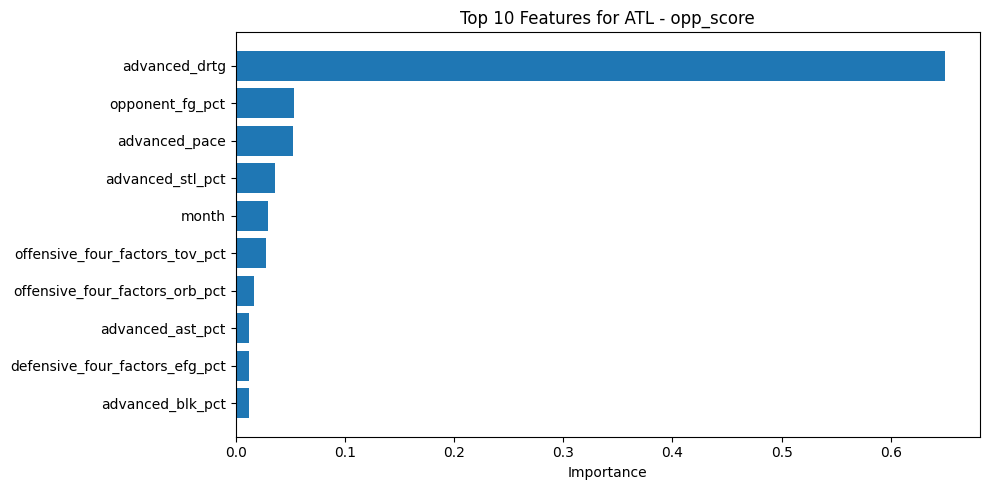

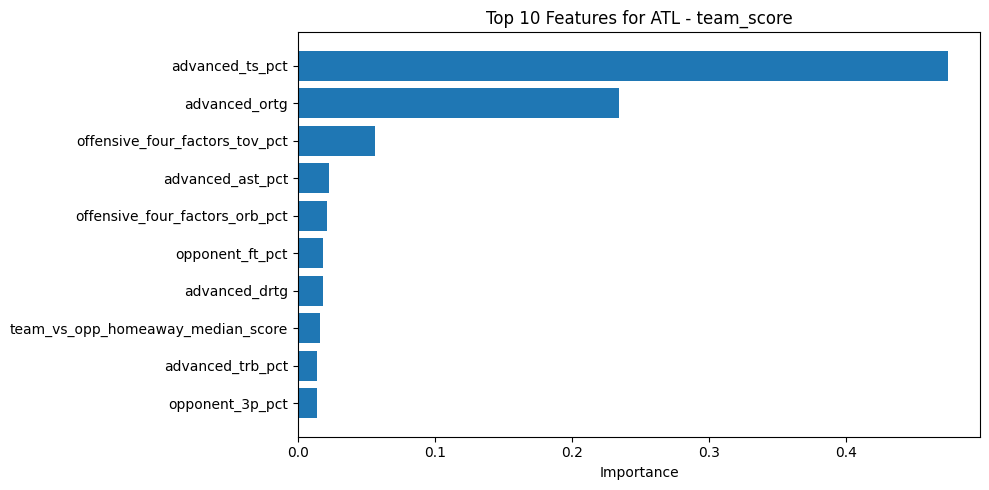

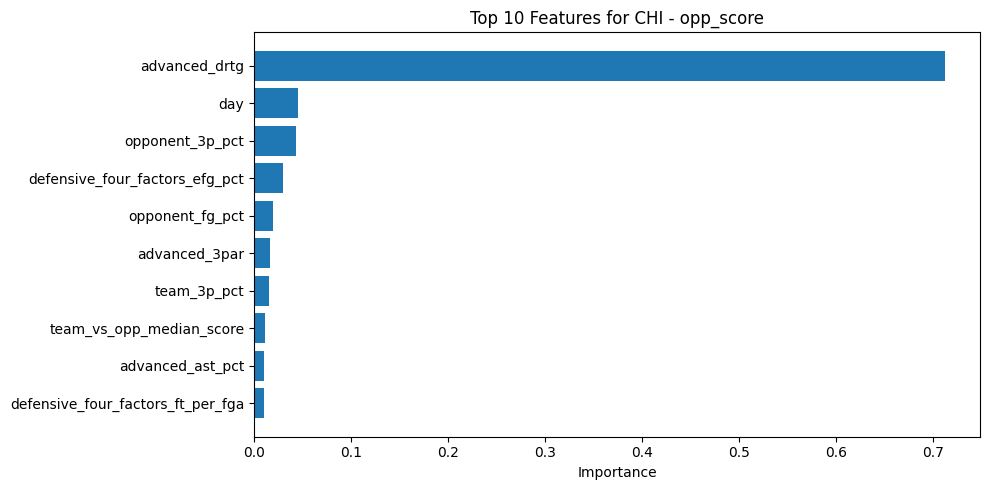

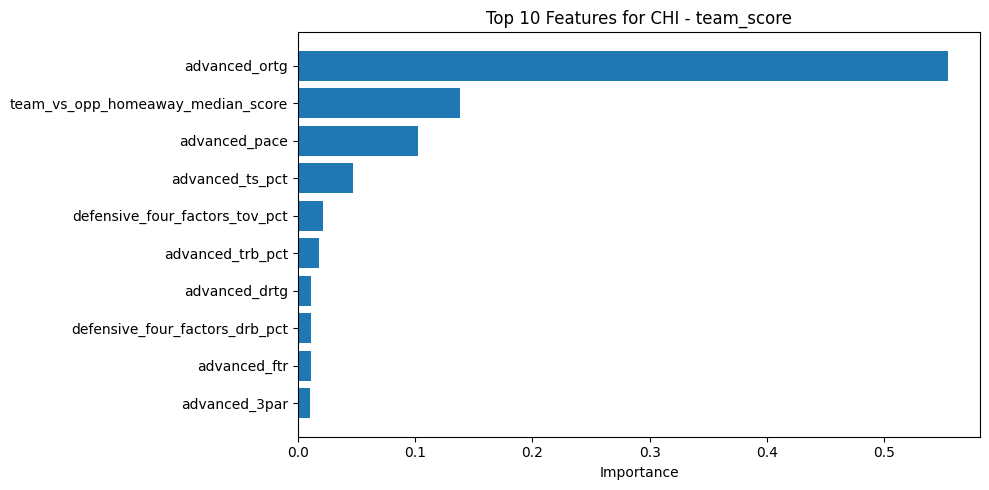

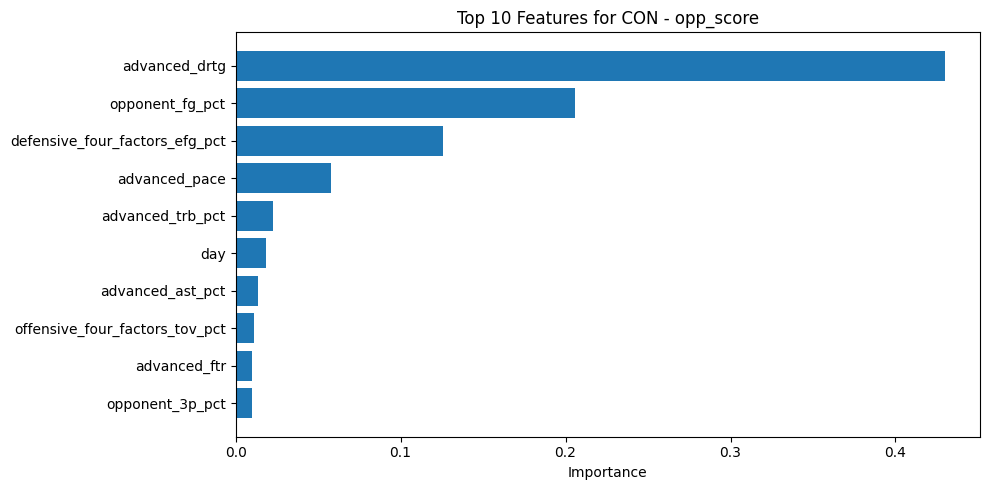

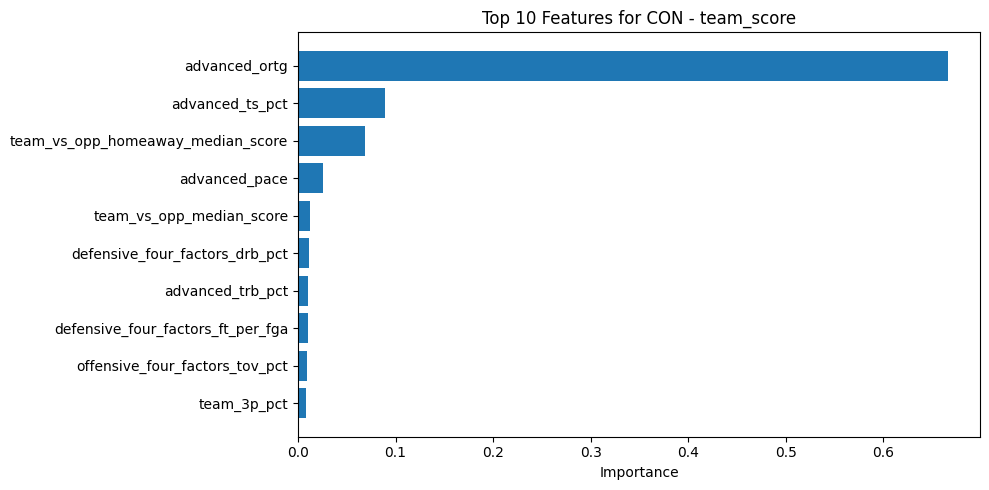

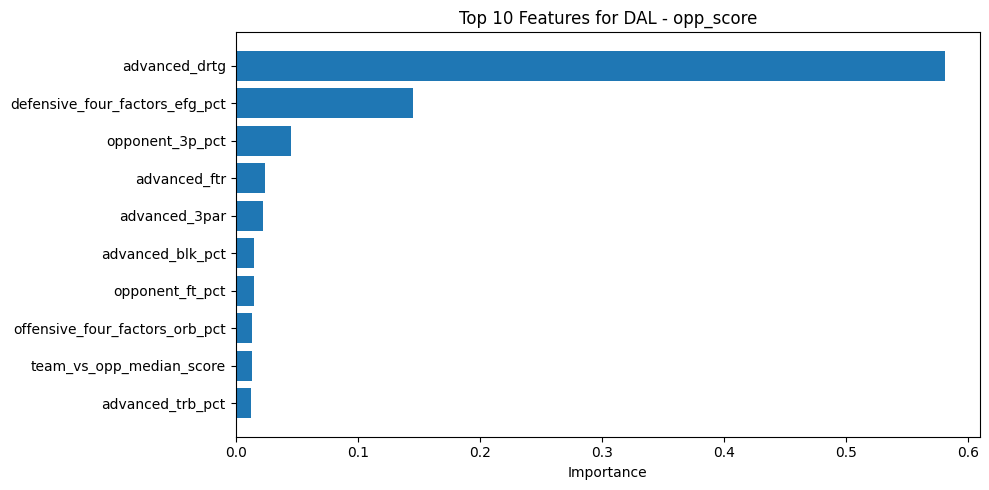

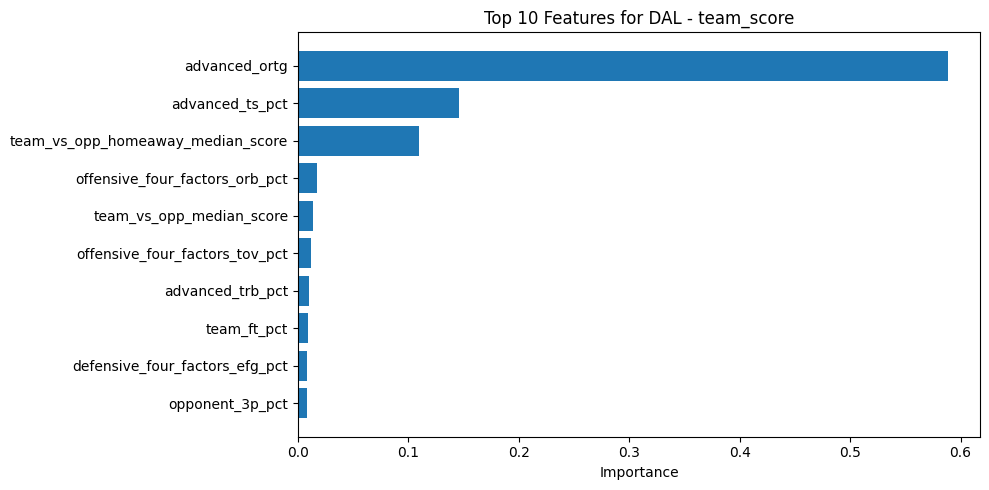

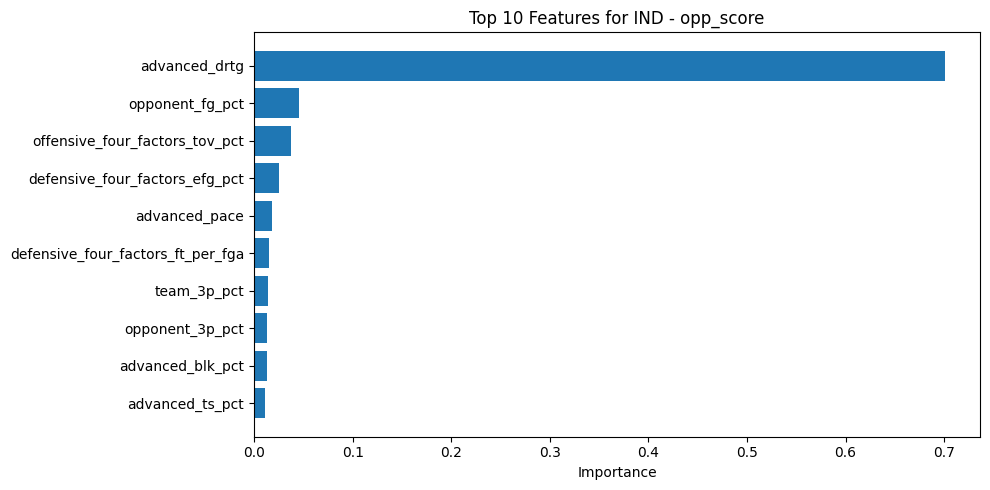

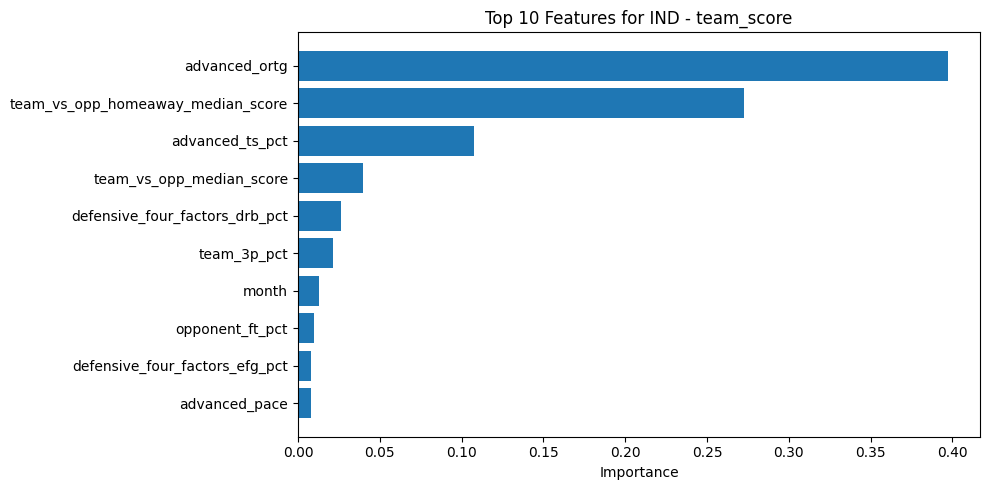

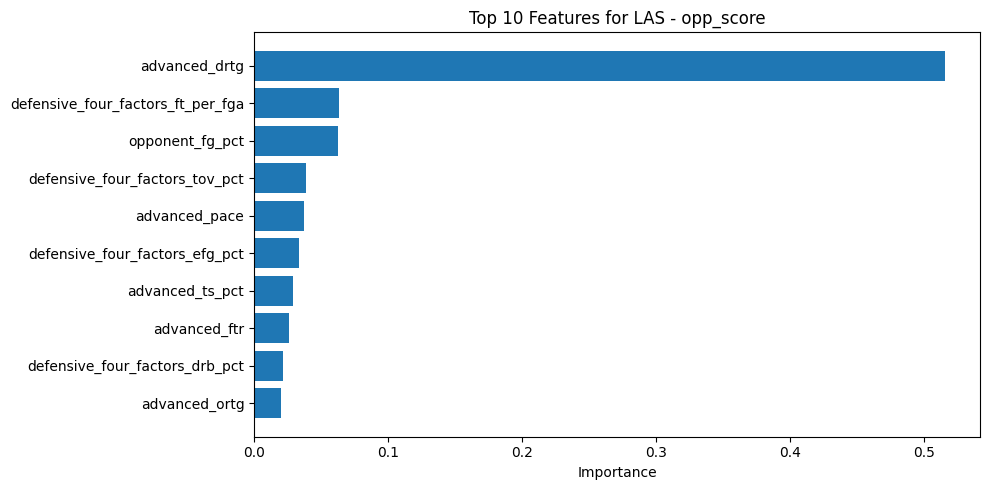

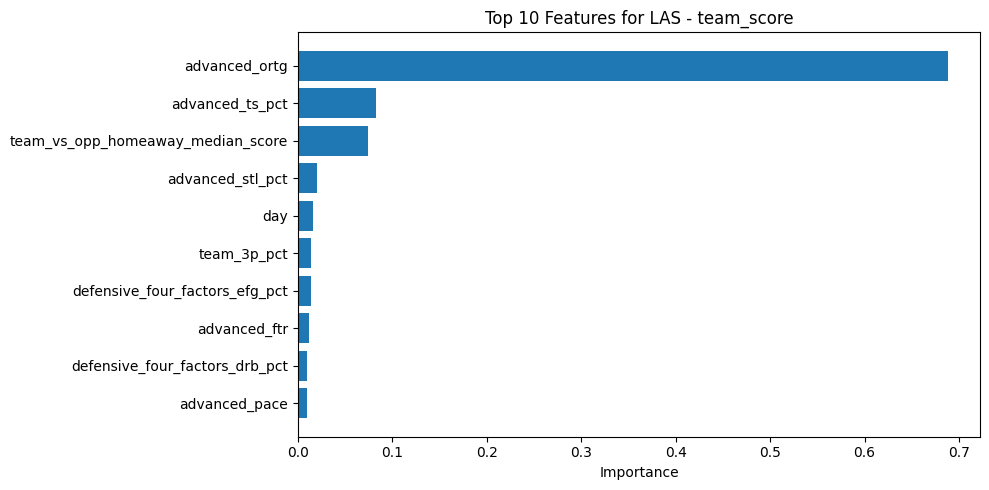

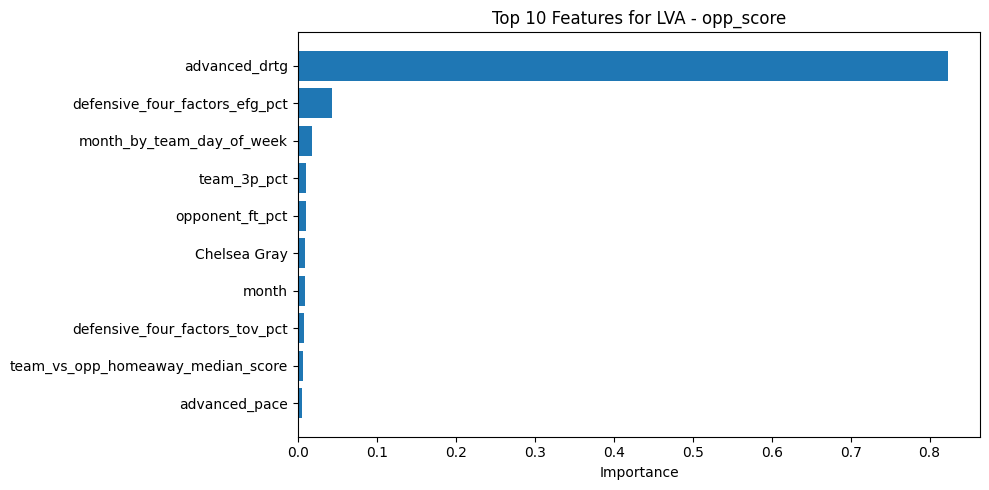

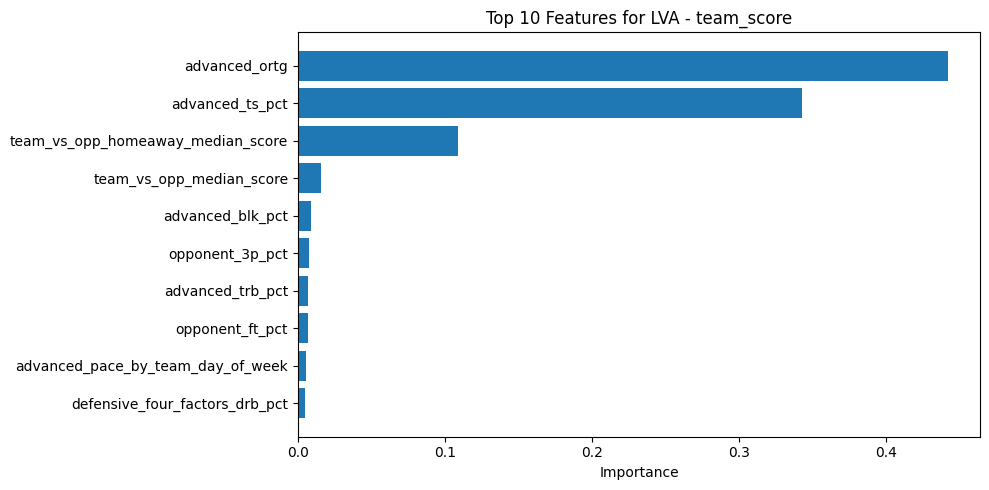

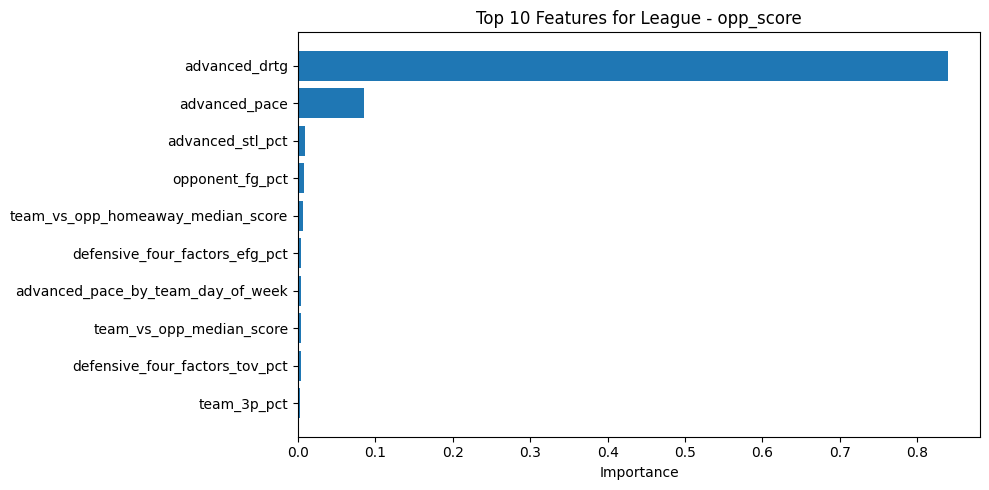

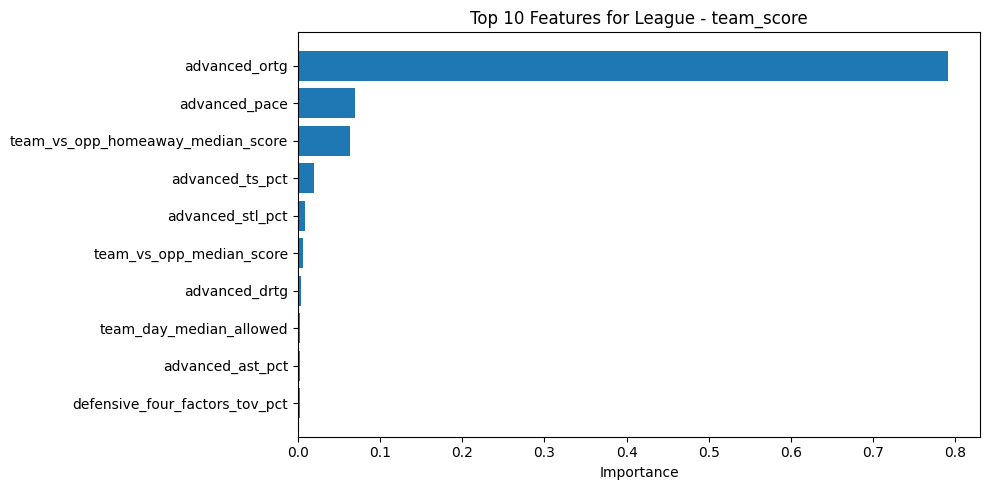

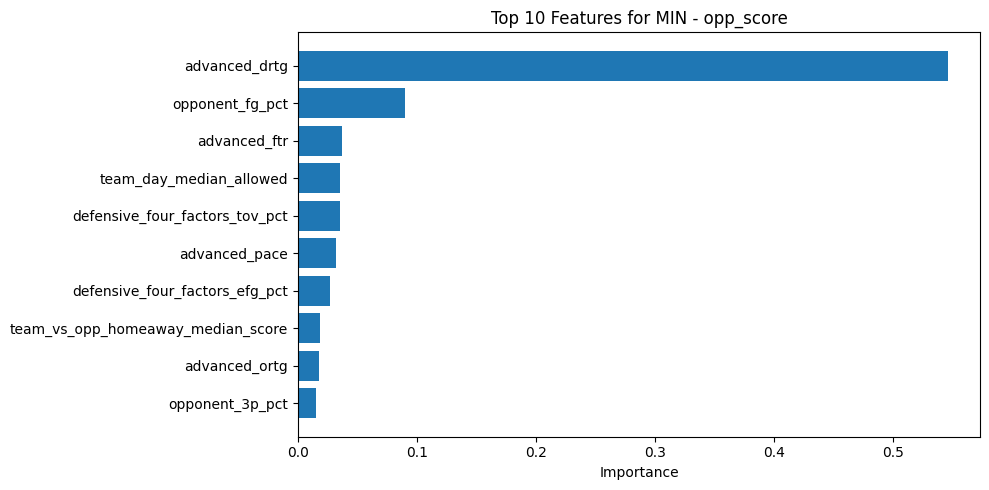

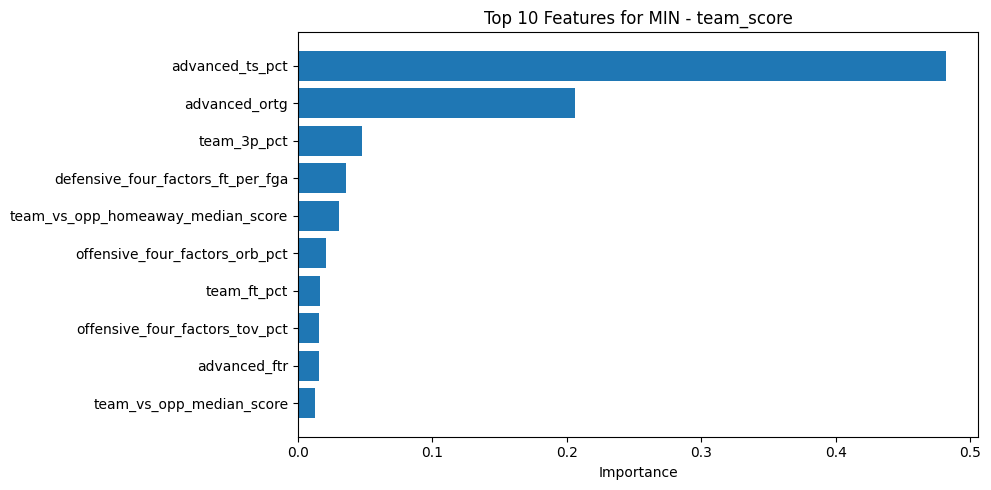

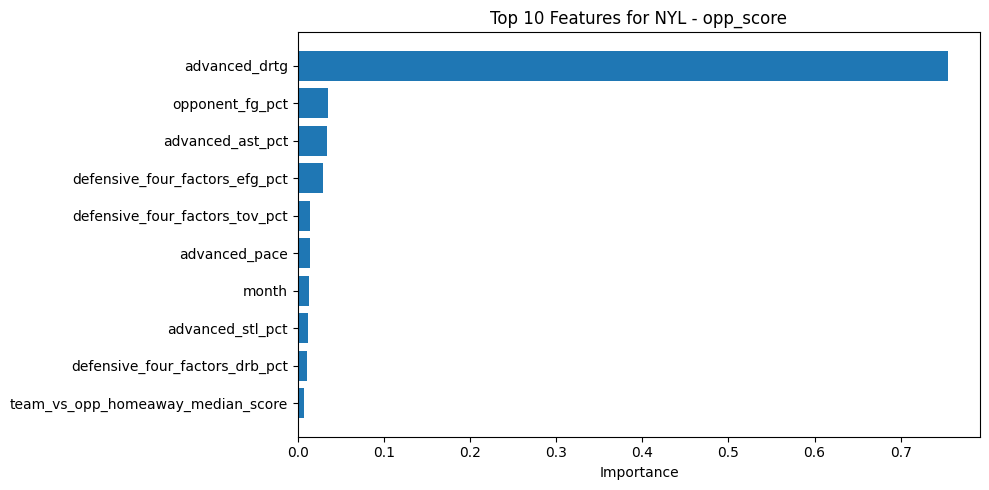

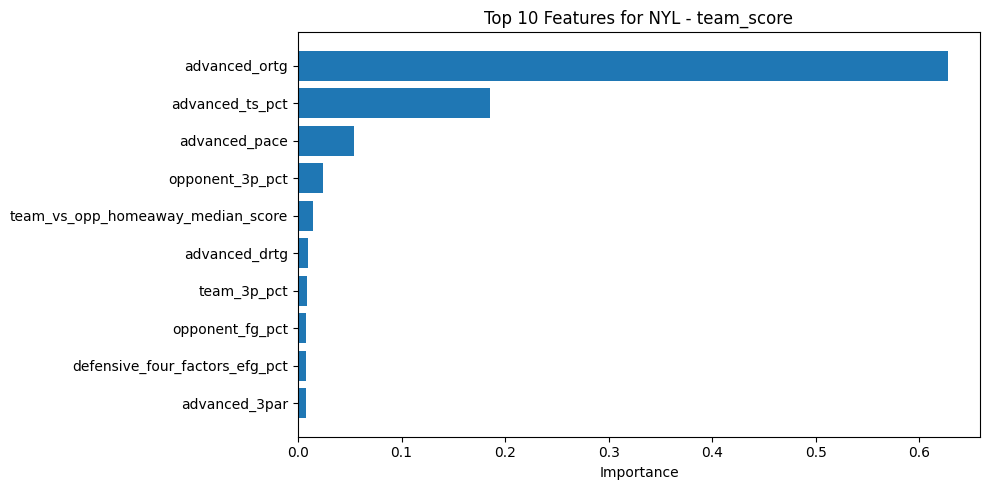

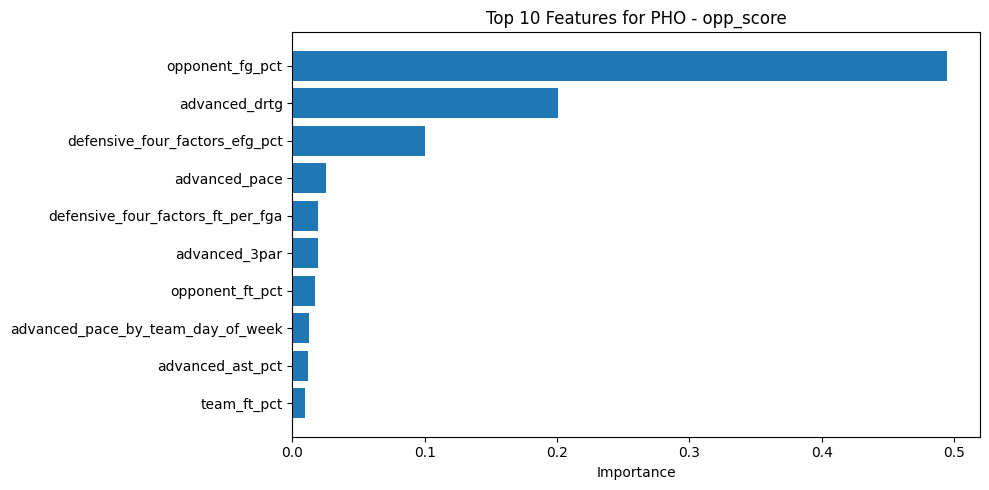

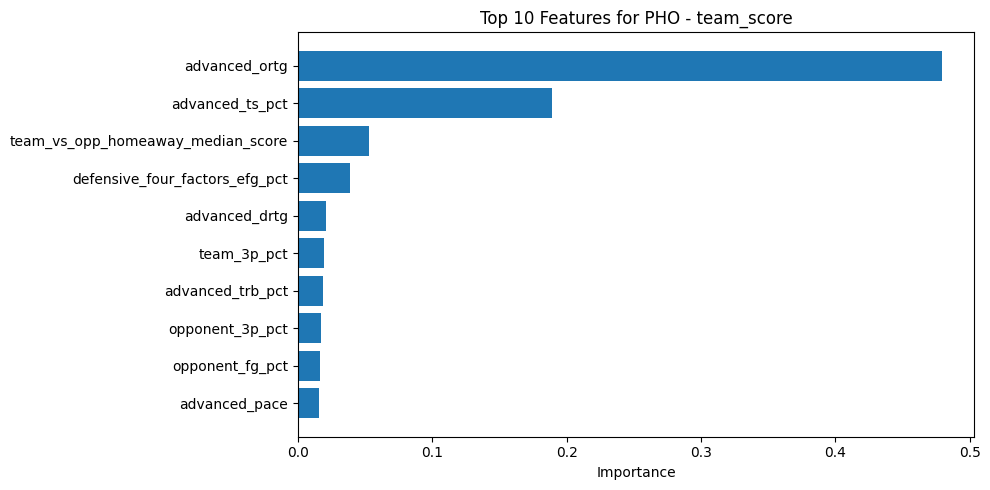

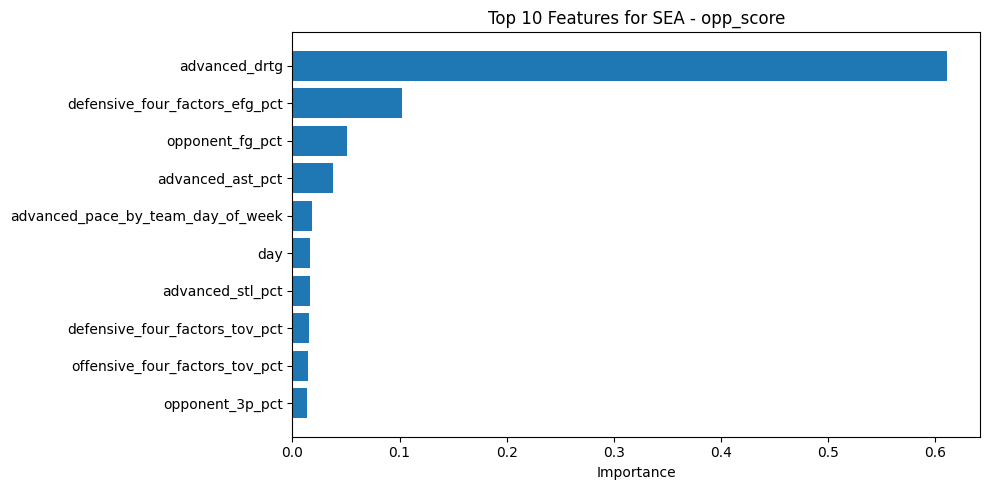

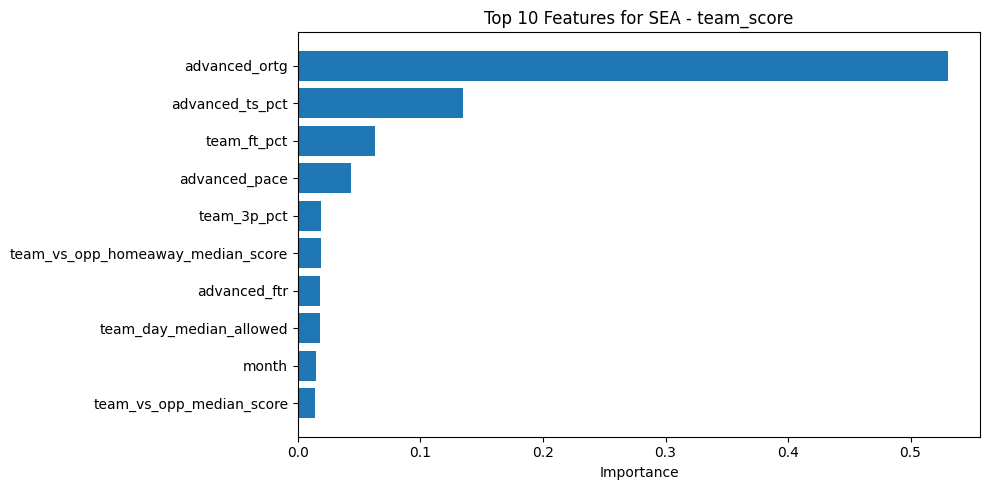

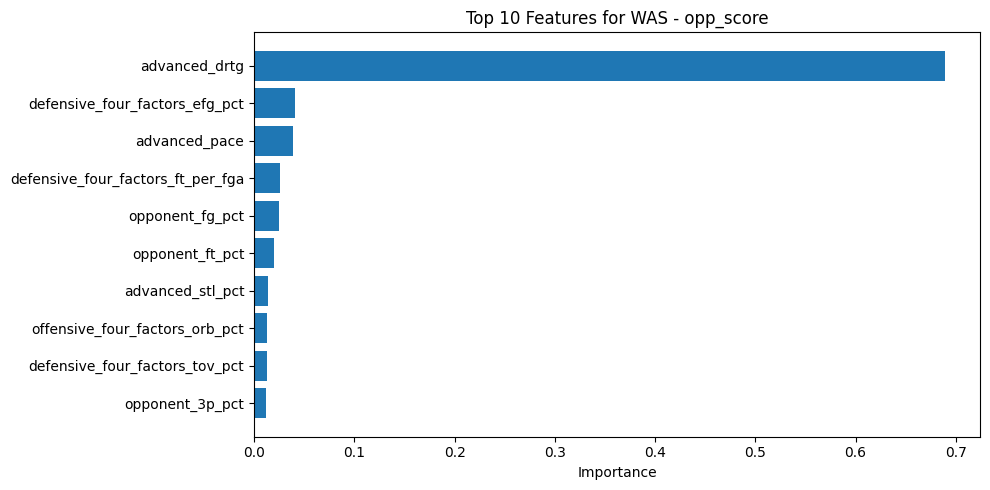

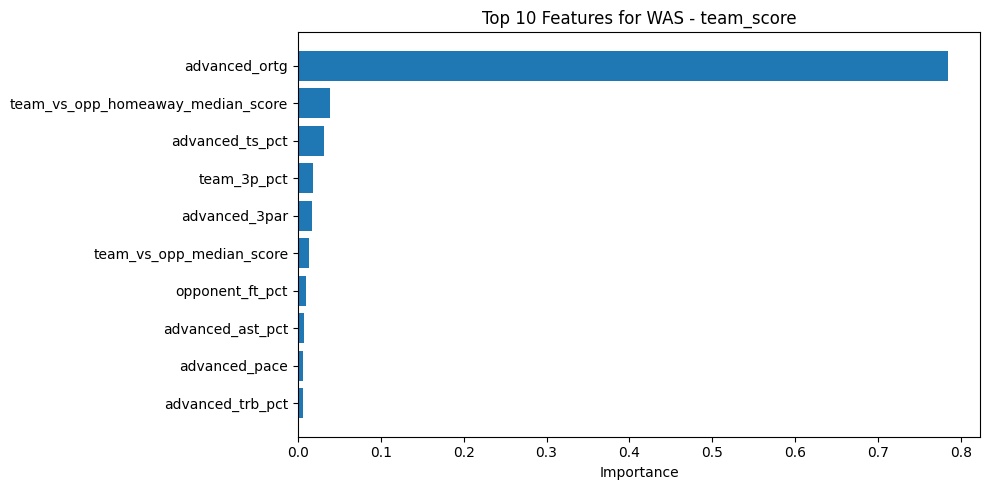

In [ ]:
# Group by team + target and get top 10 features by importance
top_features = (
    importances_df.groupby(['Model', 'Target'])
    .apply(lambda group: group.sort_values('Importance', ascending=False).head(10))
    .reset_index(drop=True)
)

# Plot each team/target combo
for (model, target), group in top_features.groupby(['Model', 'Target']):
    plt.figure(figsize=(10, 5))
    plt.barh(group['Feature'], group['Importance'])
    plt.xlabel("Importance")
    plt.title(f"Top 10 Features for {model} - {target}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [ ]:
# Filter to only player features (ending in "_played")
player_importances = importances_df[importances_df['Feature'].str.endswith('_played')]

# Group by player, average importance per target
avg_player_importance = (
    player_importances
    .groupby(['Feature', 'Target'])['Importance']
    .mean()
    .reset_index()
    .sort_values(by='Importance', ascending=False)
)

# Show top 20 overall
print(avg_player_importance.head(20))

Empty DataFrame
Columns: [Feature, Target, Importance]
Index: []


In [ ]:
# extract player column names based on dtype and value patterns
potential_player_features = [
    col for col in df.columns
    if col not in ['team', 'opp', 'team_score', 'opp_score']  # exclude targets and IDs
    and df[col].nunique() <= 2  # likely binary
    and df[col].dtype in [int, float]
    and set(df[col].dropna().unique()).issubset({0, 1})  # must be 0 or 1
]

In [ ]:
player_importances = importances_df[importances_df['Feature'].isin(potential_player_features)]

In [ ]:
player_importances

Model        Feature      Target  Importance
1684   PHO  Satou Sabally  team_score    0.000000
1674   PHO   Odyssey Sims  team_score    0.000000
1675   PHO   Odyssey Sims   opp_score    0.000000
1678   PHO   Rhyne Howard  team_score    0.000000
1679   PHO   Rhyne Howard   opp_score    0.000000
...    ...            ...         ...         ...
664    DAL  Satou Sabally  team_score    0.003573
1308   MIN  Kayla McBride  team_score    0.003747
846    IND  Temi Fagbenle  team_score    0.004940
1113   LVA   Chelsea Gray   opp_score    0.008565
1676   PHO  Rebecca Allen  team_score    0.011750

[1482 rows x 4 columns]

In [10]:
# identify binary player columns
player_columns = [
    col for col in df.columns
    if col not in ['team', 'opp', 'team_score', 'opp_score']
    and df[col].nunique() <= 2
    and set(df[col].dropna().unique()).issubset({0, 1})
]

# drop player columns where sum == 40 (played every game)
cols_to_drop = [col for col in player_columns if df[col].sum() == 40]
df = df.drop(columns=cols_to_drop)

In [11]:
df.shape

(480, 70)

In [ ]:
# save as CSV
df.to_csv("wnba_model_ready_with_top_off_def_players_v2.csv", index=False)

# download to local machine
from google.colab import files
files.download("wnba_model_ready_with_top_off_def_players_v2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save model MAE summary
mae_summary.to_csv("wnba_model_summary_v2.csv", index=False)

# Save model predictions
predictions_df.to_csv("wnba_model_predictions_v2.csv", index=False)

# Save model importances
importances_df.to_csv("wnba_model_feature_importance_v2.csv", index=False)

# download all three CSVs
files.download("wnba_model_feature_importance_v2.csv")
files.download("wnba_model_predictions_v2.csv")
files.download("wnba_model_summary_v2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# load the player game logs CSV from the data folder
df = pd.read_csv("LHL-final-final-project/data/wnba_model_ready_with_top_off_def_players_v2.csv")


# preview
df.head()

advanced_3par  advanced_ast_pct  advanced_blk_pct  advanced_drtg  \
0          0.254              58.8              22.0          100.4   
1          0.348              77.8              11.6          107.3   
2          0.306              56.7               5.6          100.5   
3          0.324              74.2               3.0          124.6   
4          0.339              73.1               4.3           84.4   

   advanced_ftr  advanced_ortg  advanced_pace  \
0         0.284          114.0           80.7   
1         0.409          103.6           82.0   
2         0.306          107.0           77.6   
3         0.206          107.0           73.8   
4         0.339           92.0           79.4   

   advanced_pace_by_team_day_of_week  advanced_stl_pct  advanced_trb_pct  ...  \
0                               79.4               9.9              49.3  ...   
1                               80.2               9.8              46.5  ...   
2                               74.8              11.6              50.7  ...   
3                               76.1              12.2              50.8  ...   
4                               79.4              11.3              53.7  ...   

   Nneka Ogwumike  Odyssey Sims  Rebecca Allen  Rhyne Howard  Sabrina Ionescu  \
0               0             0              0             1                0   
1               0             0              0             1                0   
2               0             0              0             1                0   
3               0             0              0             1                0   
4               0             0              0             1                0   

   Satou Sabally  Stefanie Dolson  Teaira McCowan  Temi Fagbenle  Tina Charles  
0              0                0               0              0             1  
1              0                0               0              0             1  
2              0                0               0              0             1  
3              0                0               0              0             1  
4              0                0               0              0             1  

[5 rows x 70 columns]

In [18]:
for col in df.columns:
  print(col)

advanced_3par
advanced_ast_pct
advanced_blk_pct
advanced_drtg
advanced_ftr
advanced_ortg
advanced_pace
advanced_pace_by_team_day_of_week
advanced_stl_pct
advanced_trb_pct
advanced_ts_pct
day
defensive_four_factors_drb_pct
defensive_four_factors_efg_pct
defensive_four_factors_ft_per_fga
defensive_four_factors_tov_pct
month
month_by_team_day_of_week
offensive_four_factors_orb_pct
offensive_four_factors_tov_pct
opponent_3p_pct
opponent_fg_pct
opponent_ft_pct
team_3p_pct
team_day_median_allowed
team_ft_pct
team_vs_opp_homeaway_median_score
team_vs_opp_median_score
team
opp
team_score
opp_score
A'ja Wilson
Aaliyah Edwards
Aari McDonald
Alanna Smith
Angel Reese
Arike Ogunbowale
Azura Stevens
Breanna Stewart
Bridget Carleton
Brittney Griner
Cameron Brink
Chelsea Gray
Chennedy Carter
Cheyenne Parker-Tyus
Diana Taurasi
Elizabeth Williams
Ezi Magbegor
Jackie Young
Jonquel Jones
Jordan Horston
Kahleah Copper
Kamilla Cardoso
Kayla McBride
Kelsey Plum
Kiah Stokes
Monique Billings
Napheesa Collier
N

In [19]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

Model team  opp  team_score  team_score_pred  team_score_mae  opp_score  \
0   ATL  ATL  CON          67            80.99           13.99         80   
1   ATL  ATL  NYL          75            80.21            5.21         81   
2   ATL  ATL  CON          78            82.41            4.41         74   
3   ATL  ATL  PHO          72            71.78            0.22         63   
4   ATL  ATL  WAS          73            79.28            6.28         67   

   opp_score_pred  opp_score_mae  
0           88.59           8.59  
1           84.87           3.87  
2           74.22           0.22  
3           70.24           7.24  
4           73.86           6.86

In [20]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# optional: flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

Model  team_score_mae_min  team_score_mae_max  team_score_mae_mean  \
0      ATL                0.22               13.99             5.931250   
1      CHI                0.59                5.92             3.138750   
2      CON                0.64                8.89             4.520000   
3      DAL                0.09                4.01             1.808750   
4      IND                1.06                8.00             2.510000   
5      LAS                0.73                7.47             3.881250   
6      LVA                0.49                9.17             3.938750   
7   League                0.02               20.01             2.081458   
8      MIN                0.72                9.50             4.776250   
9      NYL                0.23                4.51             1.477500   
10     PHO                0.78                9.87             4.007500   
11     SEA                0.59                6.42             2.961250   
12     WAS                1.03                8.94             4.471250   

    team_score_mae_median  opp_score_mae_min  opp_score_mae_max  \
0                   4.940               0.22               8.59   
1                   2.905               0.91               7.56   
2                   4.250               0.38               8.80   
3                   1.930               0.29               5.52   
4                   1.480               0.43               9.32   
5                   3.710               0.25               5.84   
6                   3.225               0.97              10.34   
7                   1.250               0.01              19.60   
8                   4.525               1.26              10.05   
9                   1.275               1.04               4.48   
10                  1.865               2.00              15.23   
11                  2.560               0.90               6.95   
12                  3.815               0.86               7.23   

    opp_score_mae_mean  opp_score_mae_median  
0             5.072500                 5.605  
1             3.073750                 2.685  
2             3.416250                 3.205  
3             2.311250                 1.340  
4             3.195000                 2.600  
5             2.362500                 2.405  
6             4.892500                 4.550  
7             1.799792                 1.060  
8             3.411250                 2.570  
9             2.343750                 1.935  
10            8.905000                 9.525  
11            4.130000                 4.295  
12            4.278750                 4.425

In [22]:
# store importances for all models
all_importances = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # get feature importances from both estimators
    team_score_importance = model.estimators_[0].feature_importances_
    opp_score_importance = model.estimators_[1].feature_importances_

    # stack into rows
    for i, feature in enumerate(X.columns):
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "team_score",
            "Importance": team_score_importance[i]
        })
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "opp_score",
            "Importance": opp_score_importance[i]
        })

# build final DataFrame
importances_df = pd.DataFrame(all_importances)

# optional: sort by importance descending
importances_df = importances_df.sort_values(by="Importance", ascending=False)

importances_df.head(20)

Model          Feature      Target  Importance
1591  League    advanced_drtg   opp_score    0.838629
799      LVA    advanced_drtg   opp_score    0.815058
1462     WAS    advanced_ortg  team_score    0.797798
1594  League    advanced_ortg  team_score    0.790801
1063     NYL    advanced_drtg   opp_score    0.722633
139      CHI    advanced_drtg   opp_score    0.707430
670      LAS    advanced_ortg  team_score    0.703566
535      IND    advanced_drtg   opp_score    0.696782
1459     WAS    advanced_drtg   opp_score    0.690130
274      CON    advanced_ortg  team_score    0.660985
7        ATL    advanced_drtg   opp_score    0.646872
1066     NYL    advanced_ortg  team_score    0.643545
1327     SEA    advanced_drtg   opp_score    0.599167
406      DAL    advanced_ortg  team_score    0.591084
403      DAL    advanced_drtg   opp_score    0.581064
142      CHI    advanced_ortg  team_score    0.573683
931      MIN    advanced_drtg   opp_score    0.527204
1231     PHO  opponent_fg_pct   opp_score    0.513040
944      MIN  advanced_ts_pct  team_score    0.511985
1330     SEA    advanced_ortg  team_score    0.508534

<ipython-input-23-7fd42919fbe4>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sort_values('Importance', ascending=False).head(10))


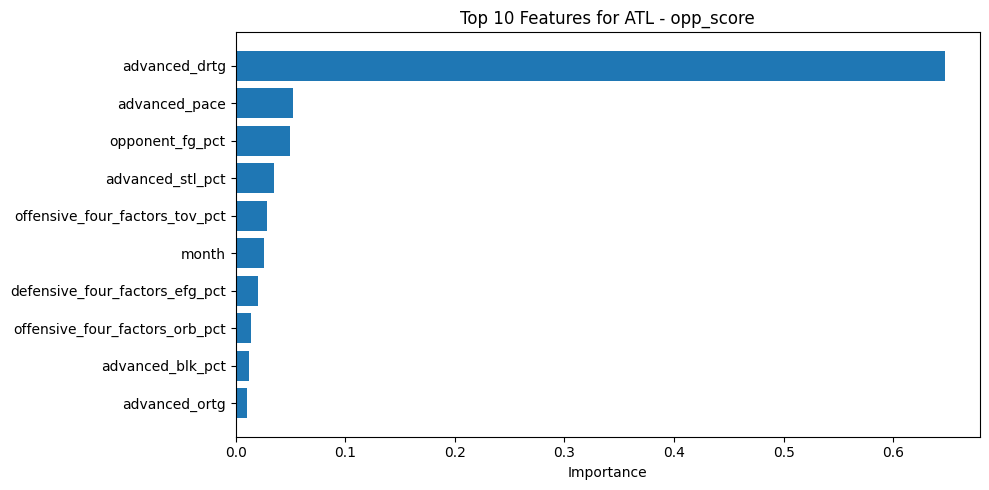

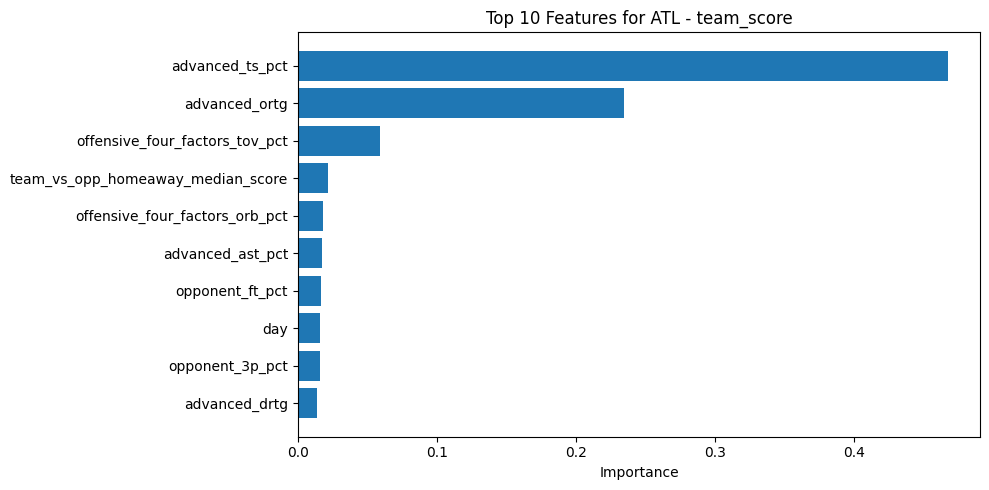

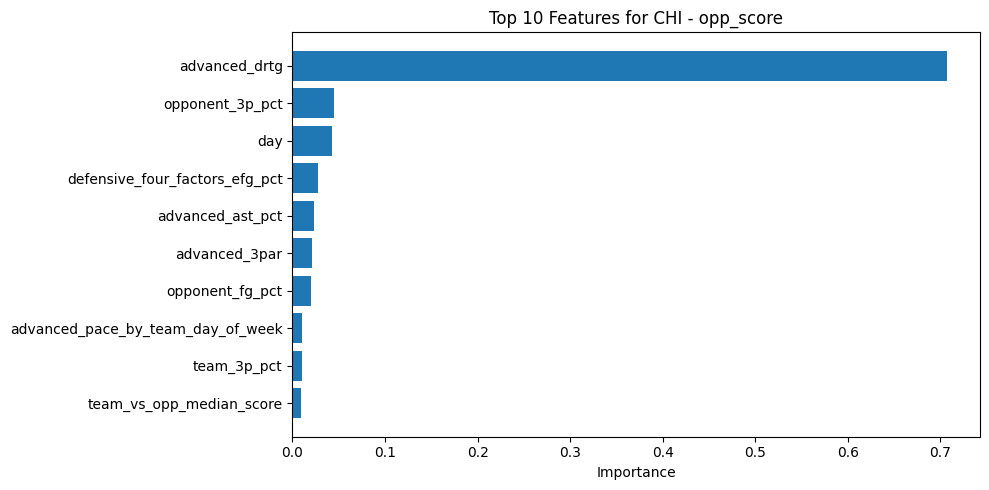

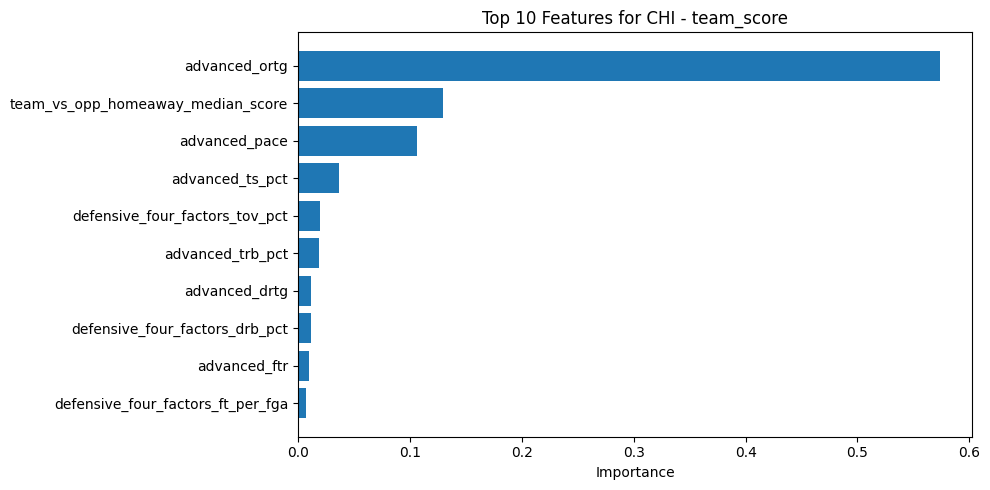

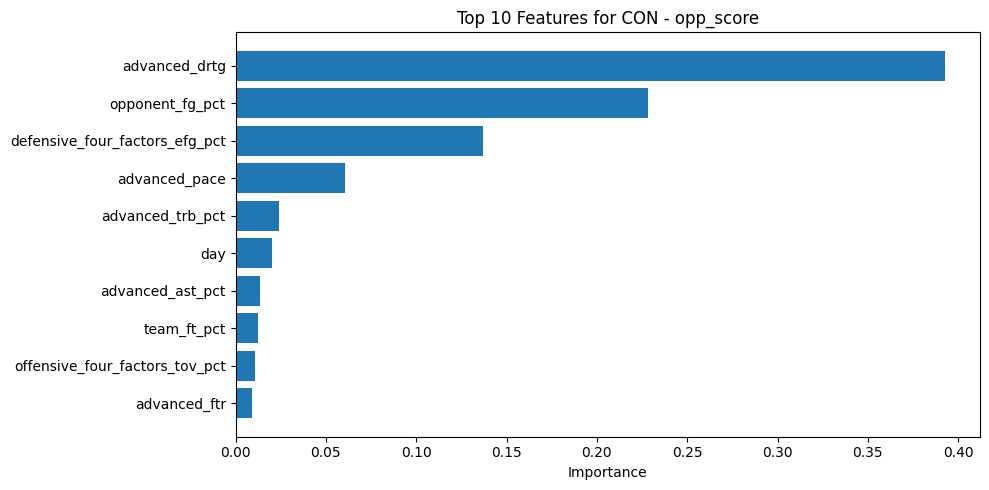

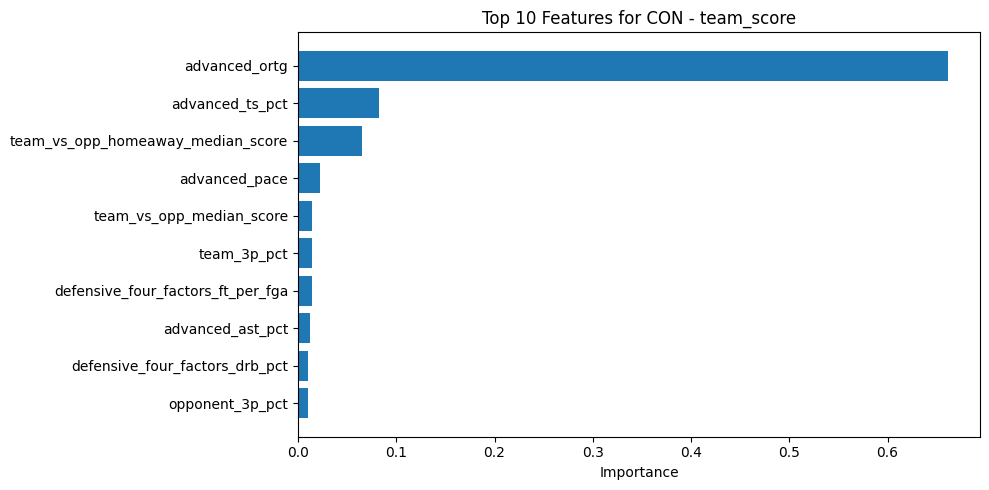

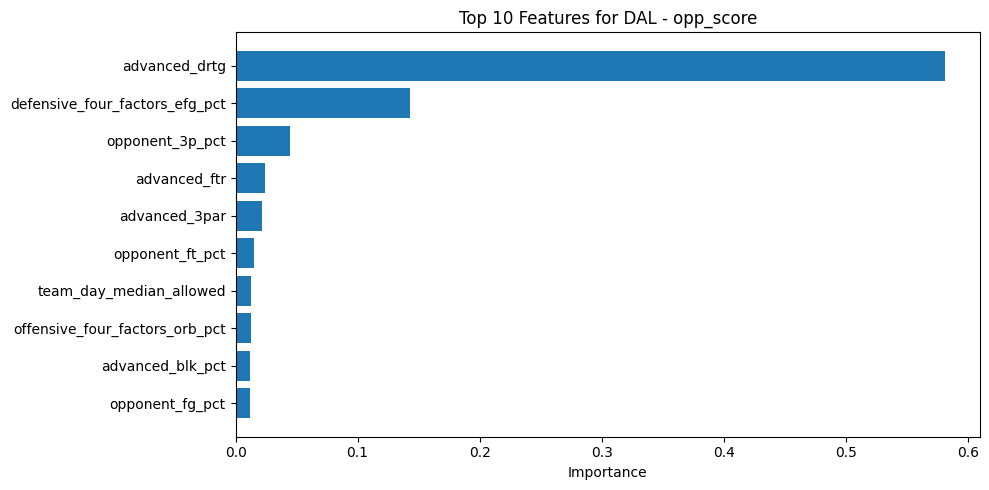

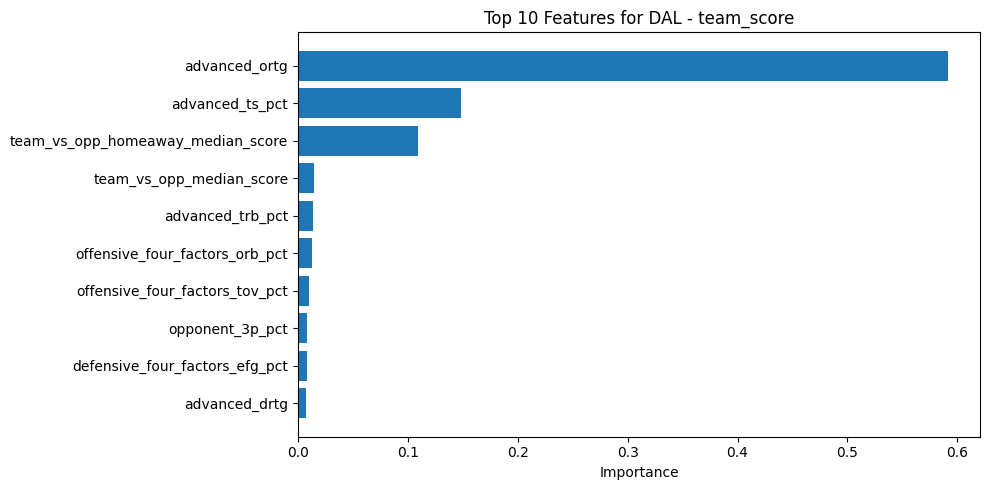

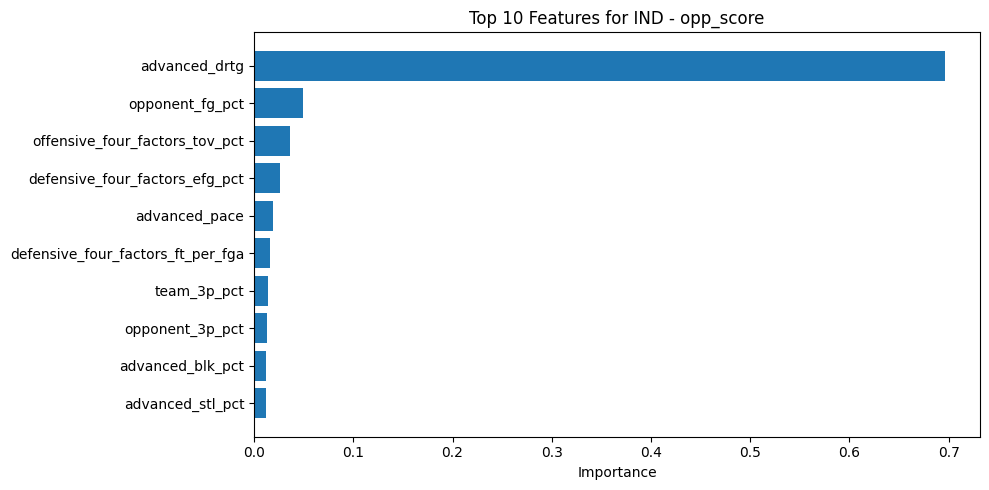

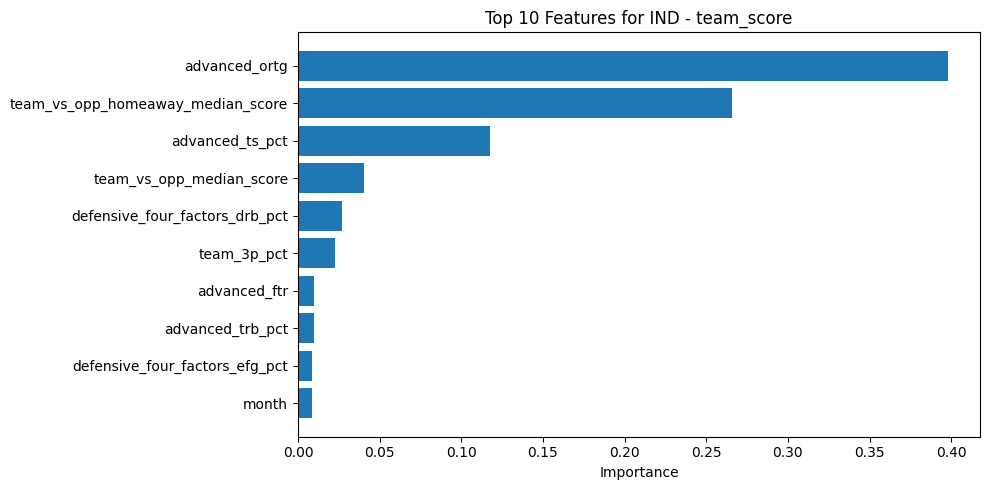

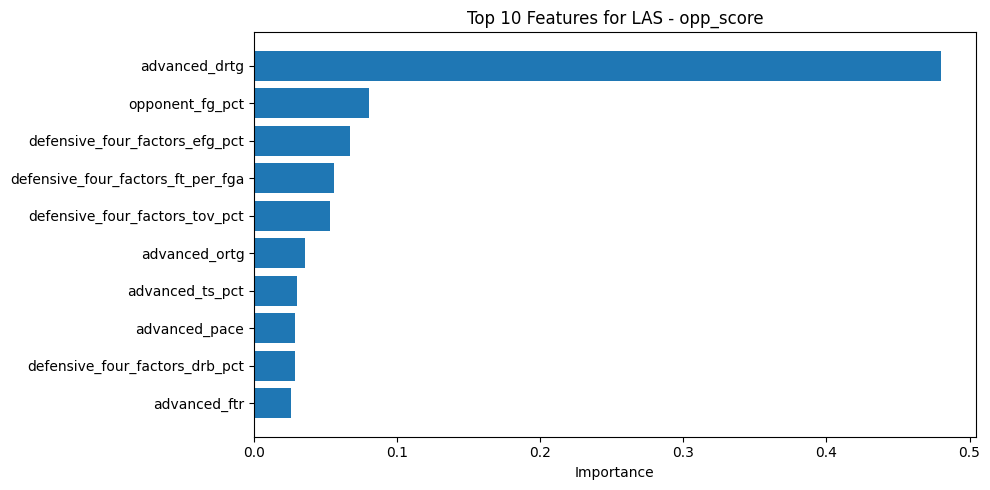

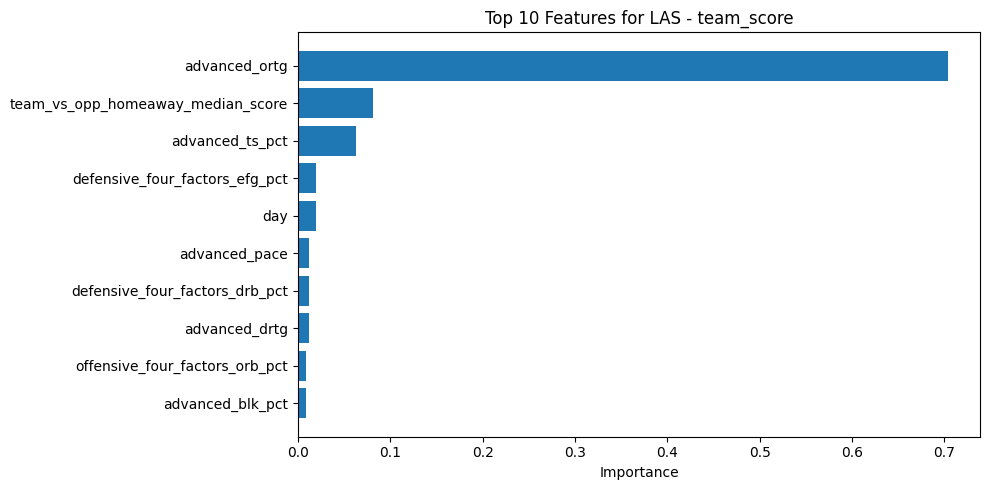

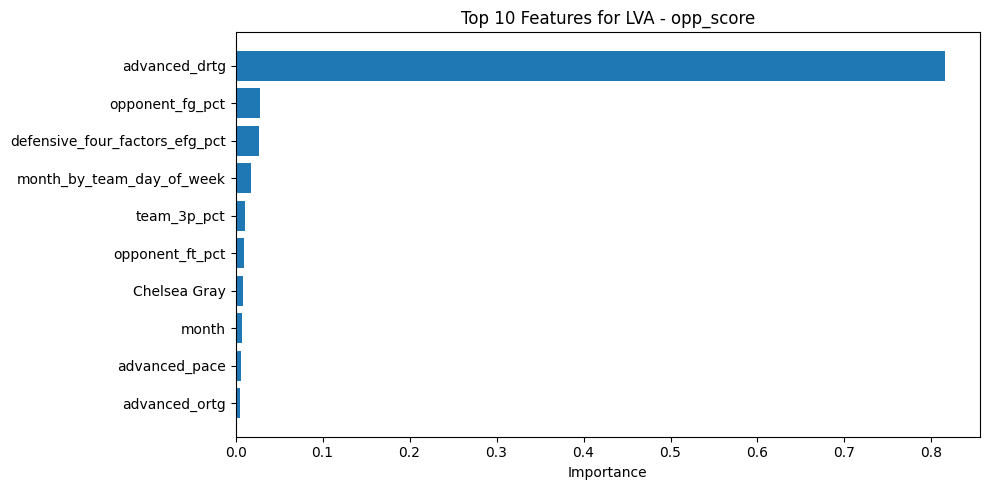

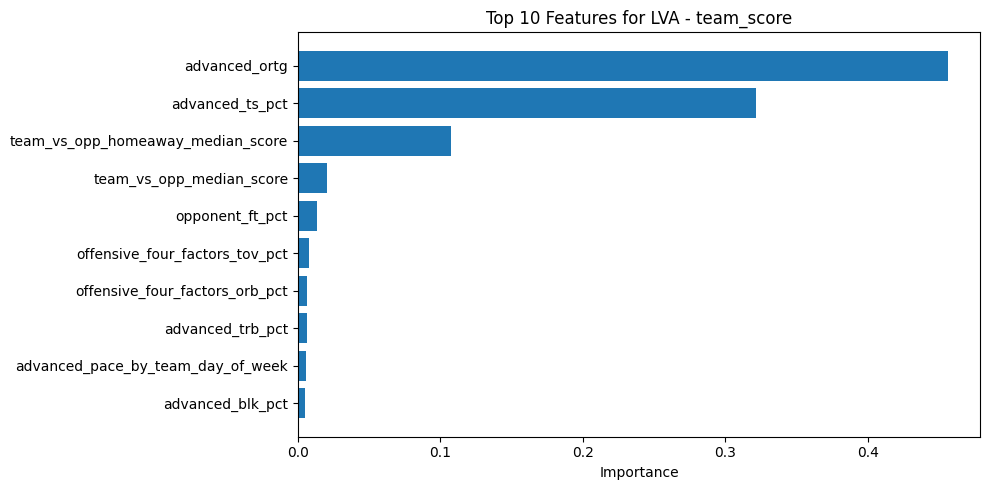

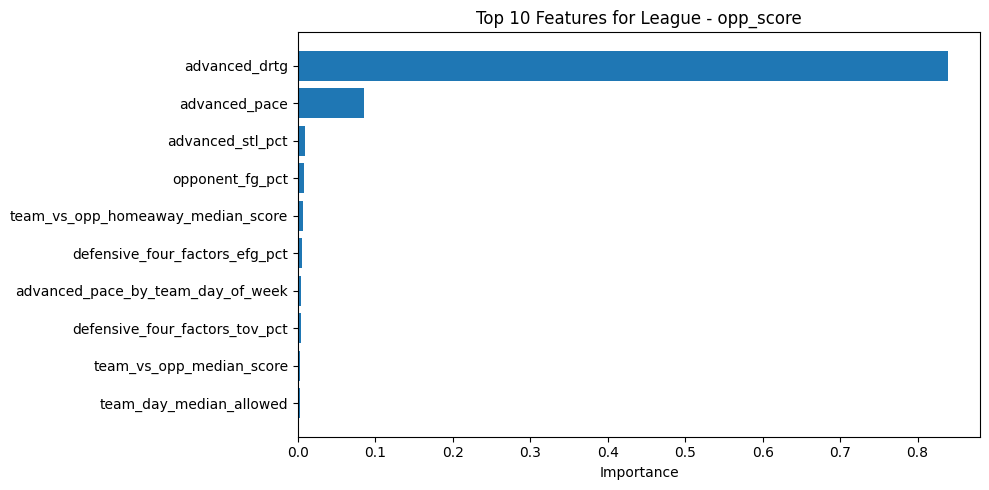

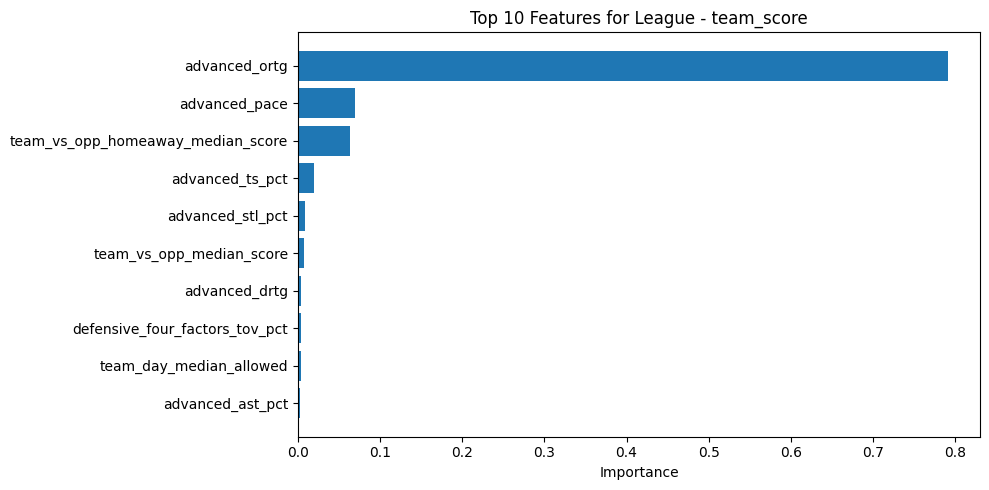

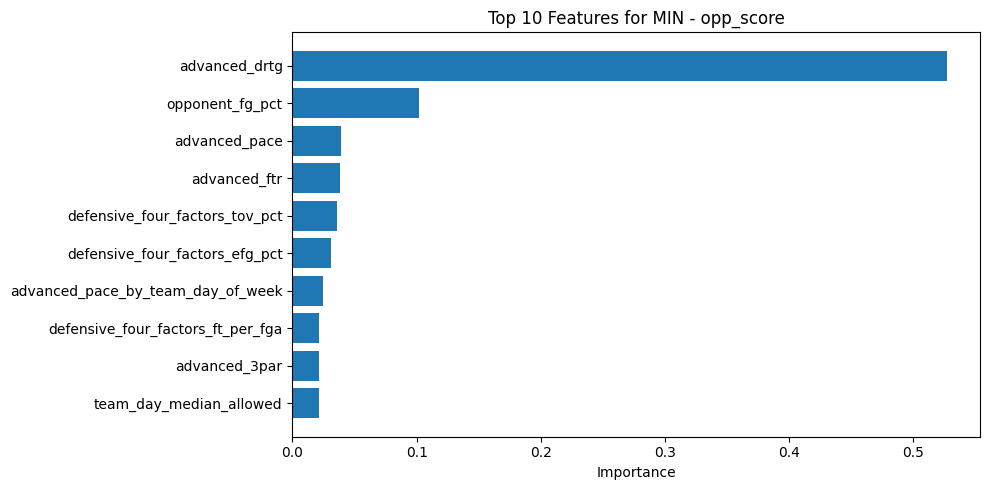

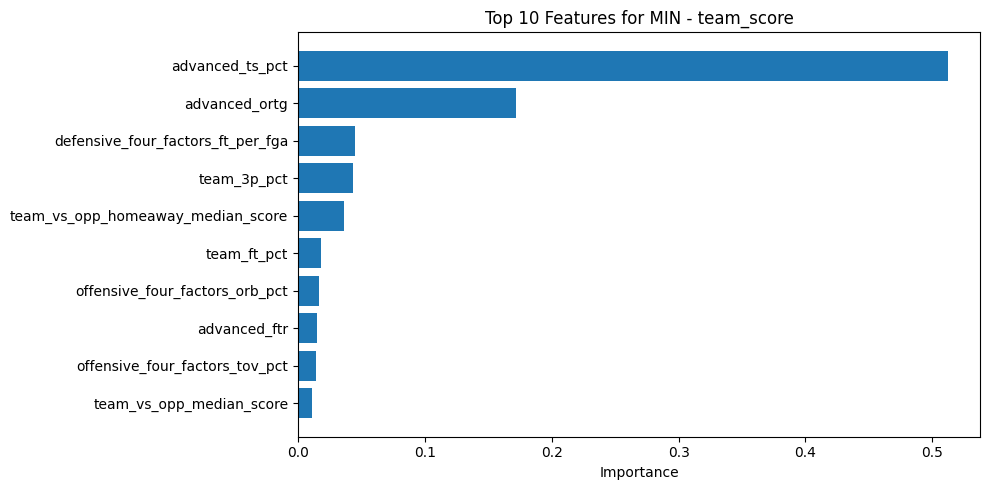

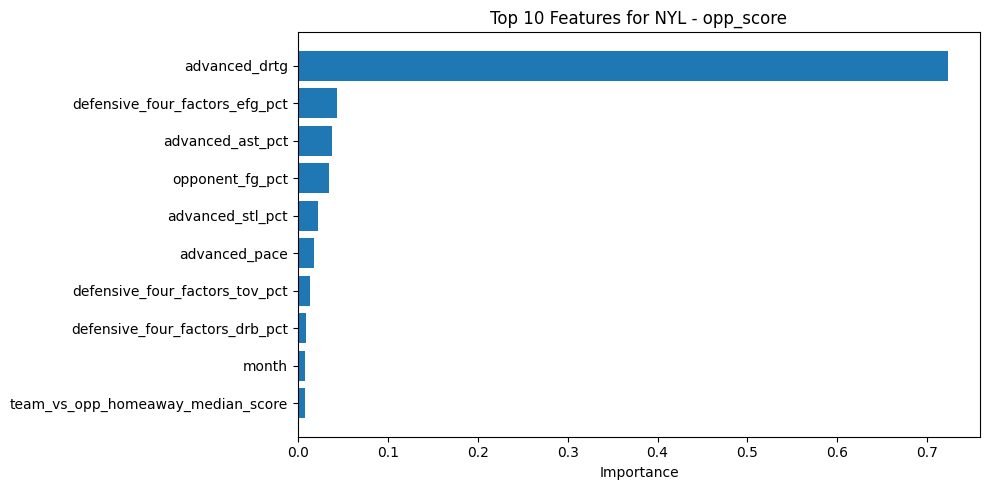

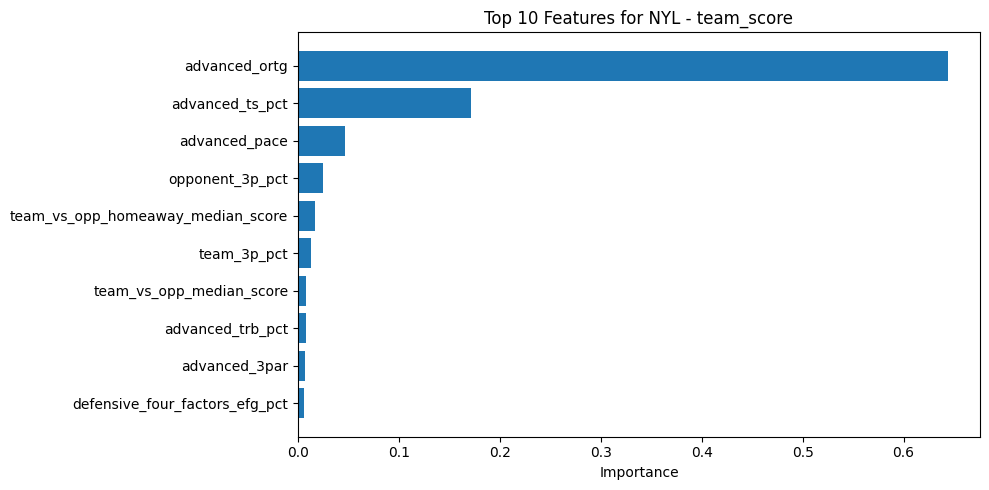

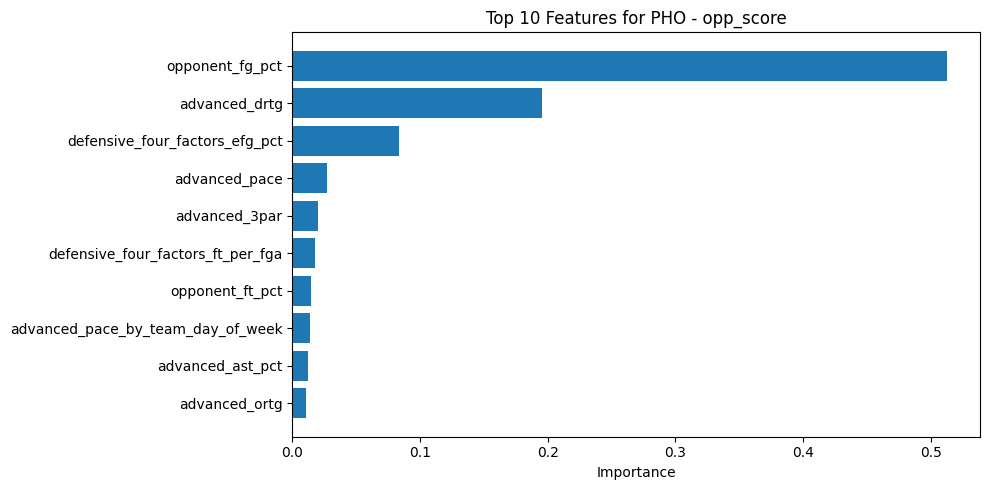

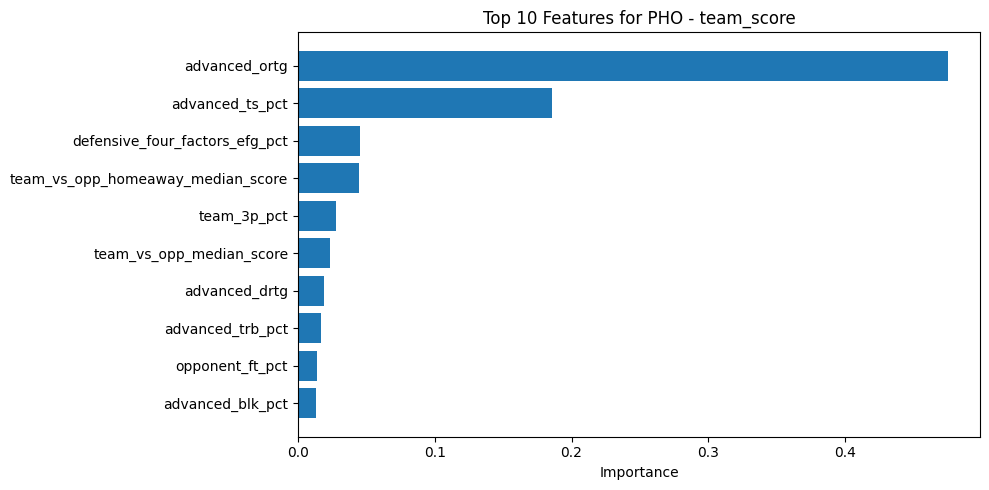

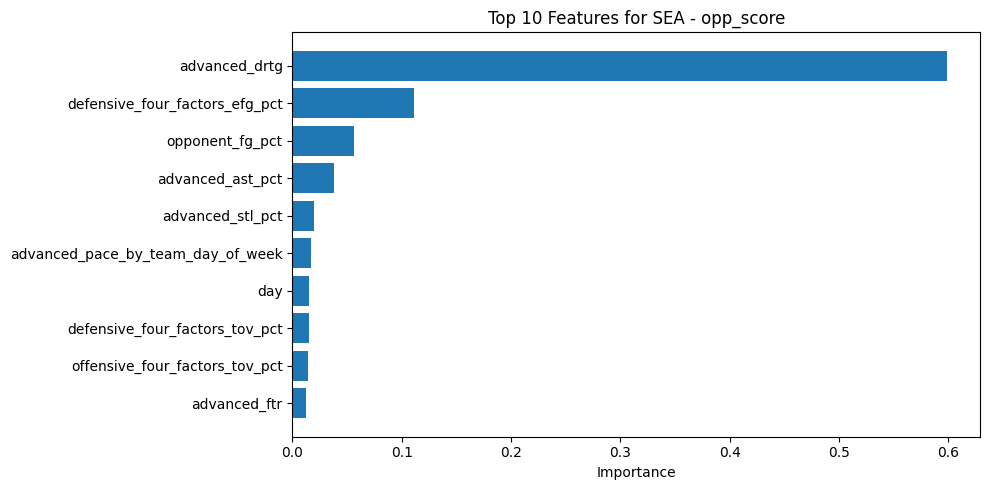

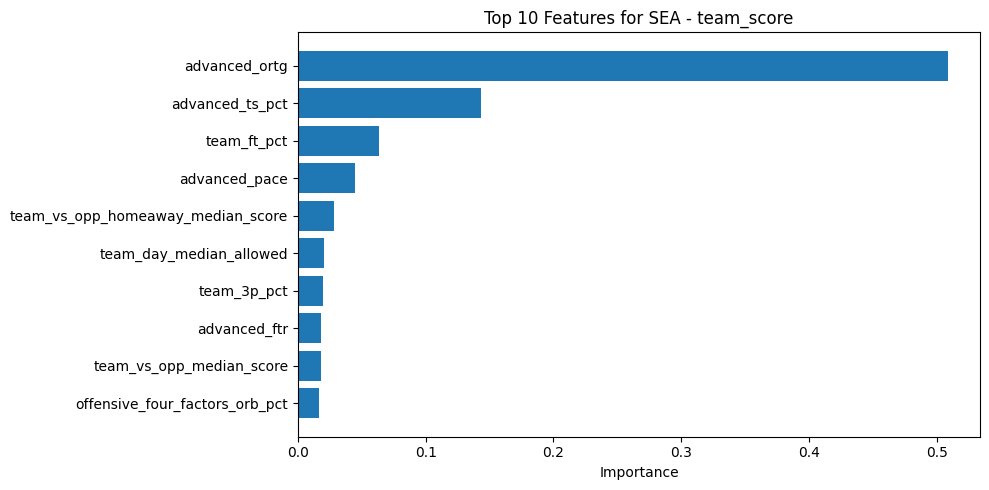

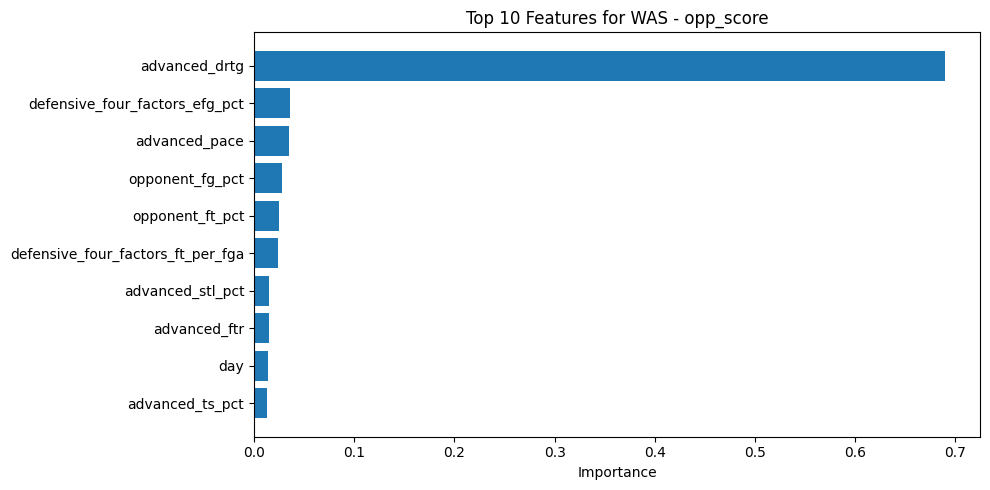

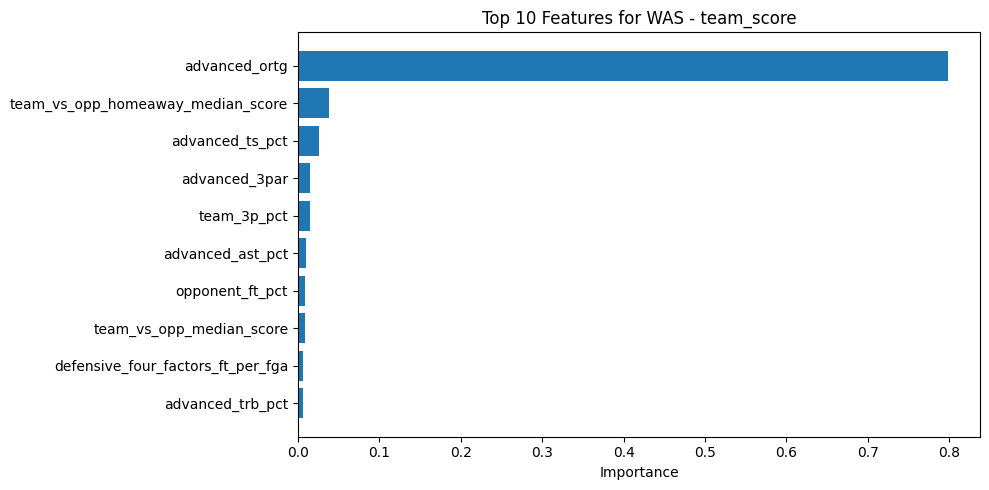

In [23]:
# Group by team + target and get top 10 features by importance
top_features = (
    importances_df.groupby(['Model', 'Target'])
    .apply(lambda group: group.sort_values('Importance', ascending=False).head(10))
    .reset_index(drop=True)
)

# Plot each team/target combo
for (model, target), group in top_features.groupby(['Model', 'Target']):
    plt.figure(figsize=(10, 5))
    plt.barh(group['Feature'], group['Importance'])
    plt.xlabel("Importance")
    plt.title(f"Top 10 Features for {model} - {target}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [25]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team[["advanced_ortg", "advanced_drtg"]]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

Model team  opp  team_score  team_score_pred  team_score_mae  opp_score  \
0   ATL  ATL  CON          67            79.63           12.63         80   
1   ATL  ATL  NYL          75            78.21            3.21         81   
2   ATL  ATL  CON          78            80.77            2.77         74   
3   ATL  ATL  PHO          72            80.60            8.60         63   
4   ATL  ATL  WAS          73            71.05            1.95         67   

   opp_score_pred  opp_score_mae  
0           92.05          12.05  
1           84.47           3.47  
2           74.42           0.42  
3           67.28           4.28  
4           69.68           2.68

In [26]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# optional: flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

Model  team_score_mae_min  team_score_mae_max  team_score_mae_mean  \
0      ATL                0.69               12.63             4.792500   
1      CHI                0.56                3.26             1.831250   
2      CON                0.36               12.89             4.331250   
3      DAL                1.29                9.95             4.658750   
4      IND                2.20               10.37             5.475000   
5      LAS                0.02                6.76             3.632500   
6      LVA                0.77               10.68             4.738750   
7   League                0.02               26.79             4.104687   
8      MIN                0.06               10.10             3.218750   
9      NYL                0.20                6.18             2.653750   
10     PHO                0.85               13.74             5.027500   
11     SEA                0.28                9.12             3.515000   
12     WAS                2.19                8.89             4.566250   

    team_score_mae_median  opp_score_mae_min  opp_score_mae_max  \
0                   3.460               0.42              12.05   
1                   1.660               0.08               6.28   
2                   4.125               0.10               8.94   
3                   3.780               0.18               6.45   
4                   5.250               0.38               9.77   
5                   3.535               0.91               7.14   
6                   4.070               0.15               5.45   
7                   3.625               0.03              23.89   
8                   2.910               0.23               5.53   
9                   2.550               1.39               4.95   
10                  3.470               0.35              15.15   
11                  2.310               0.22              11.78   
12                  3.870               0.77              10.15   

    opp_score_mae_mean  opp_score_mae_median  
0             4.122500                 3.795  
1             2.250000                 2.090  
2             3.155000                 1.985  
3             3.115000                 3.235  
4             4.458750                 4.280  
5             2.666250                 1.780  
6             3.393750                 3.705  
7             4.066979                 3.295  
8             2.435000                 2.375  
9             2.631250                 2.055  
10            5.553750                 3.010  
11            4.792500                 3.565  
12            3.726250                 3.045

In [30]:
# store importances for all models
all_importances = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features
    X = df_team[["advanced_ortg", "advanced_drtg"]]
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # get feature importances from both estimators
    team_score_importance = model.estimators_[0].feature_importances_
    opp_score_importance = model.estimators_[1].feature_importances_

    # stack into rows
    for i, feature in enumerate(X.columns):
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "team_score",
            "Importance": team_score_importance[i]
        })
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "opp_score",
            "Importance": opp_score_importance[i]
        })

# build final DataFrame
importances_df = pd.DataFrame(all_importances)

# optional: sort by importance descending
importances_df = importances_df.sort_values(by="Importance", ascending=False)

importances_df.head(20)

Model        Feature      Target  Importance
27     LVA  advanced_drtg   opp_score    0.950601
24     LVA  advanced_ortg  team_score    0.948602
32     NYL  advanced_ortg  team_score    0.946900
7      CHI  advanced_drtg   opp_score    0.939514
40     SEA  advanced_ortg  team_score    0.935104
8      CON  advanced_ortg  team_score    0.932242
12     DAL  advanced_ortg  team_score    0.931599
43     SEA  advanced_drtg   opp_score    0.929647
35     NYL  advanced_drtg   opp_score    0.928181
44     WAS  advanced_ortg  team_score    0.924899
20     LAS  advanced_ortg  team_score    0.917135
51  League  advanced_drtg   opp_score    0.914717
48  League  advanced_ortg  team_score    0.913502
28     MIN  advanced_ortg  team_score    0.907467
19     IND  advanced_drtg   opp_score    0.903833
16     IND  advanced_ortg  team_score    0.896224
39     PHO  advanced_drtg   opp_score    0.896100
0      ATL  advanced_ortg  team_score    0.893113
23     LAS  advanced_drtg   opp_score    0.892268
4      CHI  advanced_ortg  team_score    0.891719

<ipython-input-31-7fd42919fbe4>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sort_values('Importance', ascending=False).head(10))


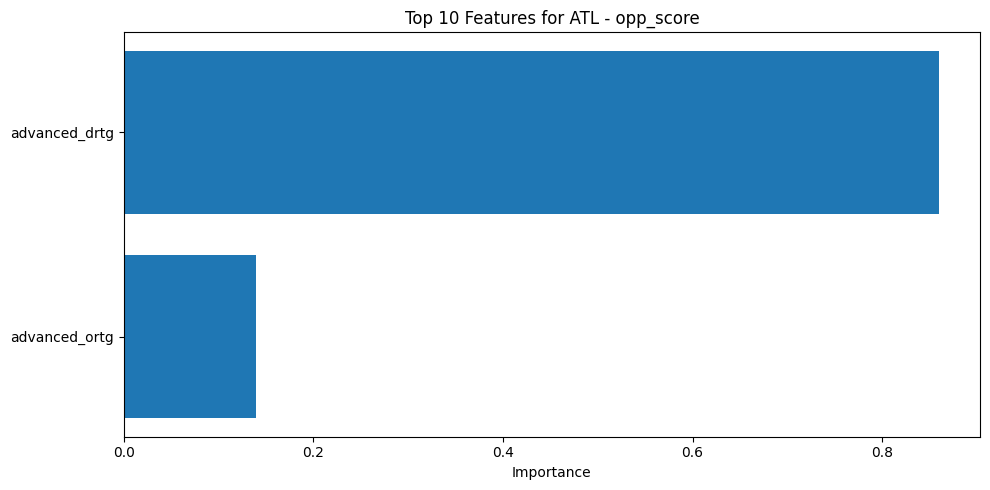

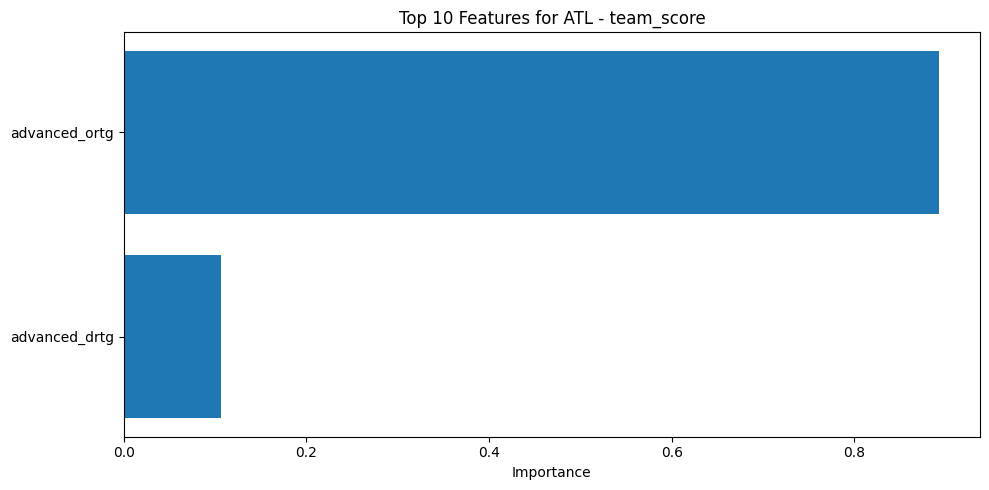

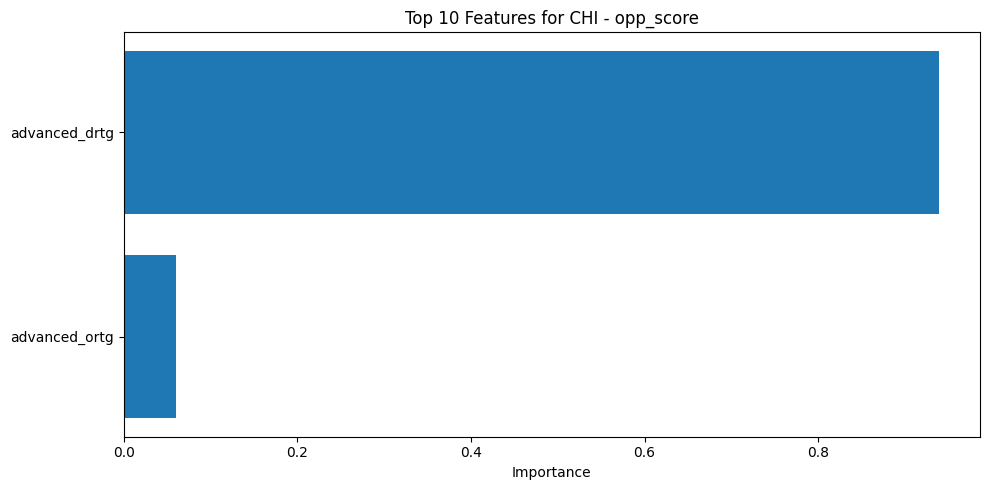

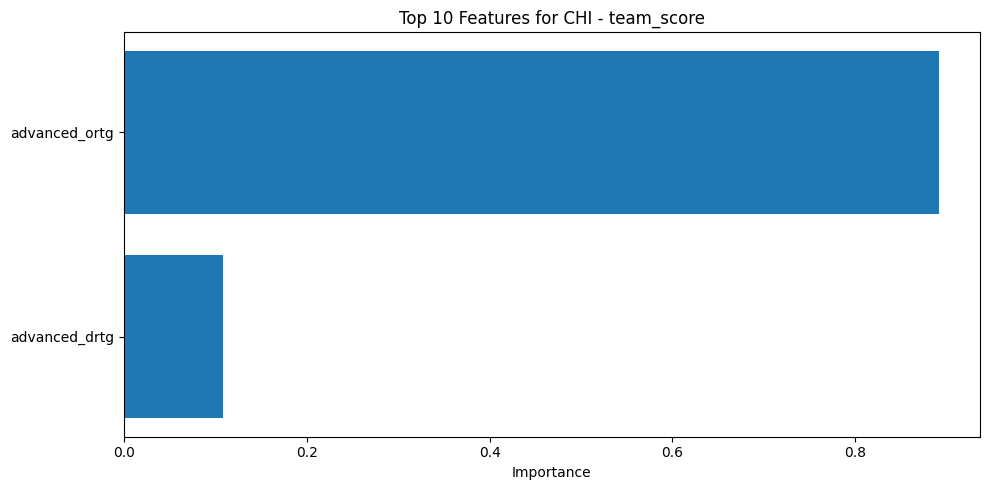

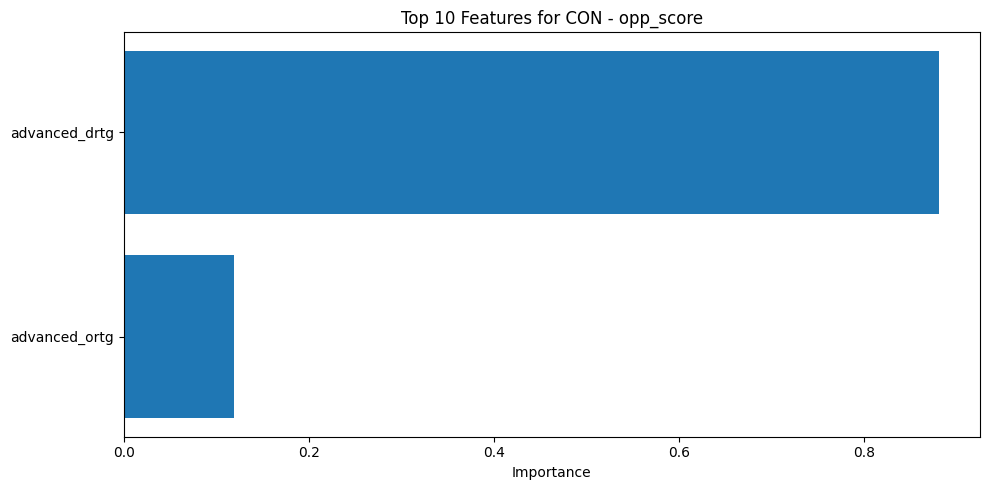

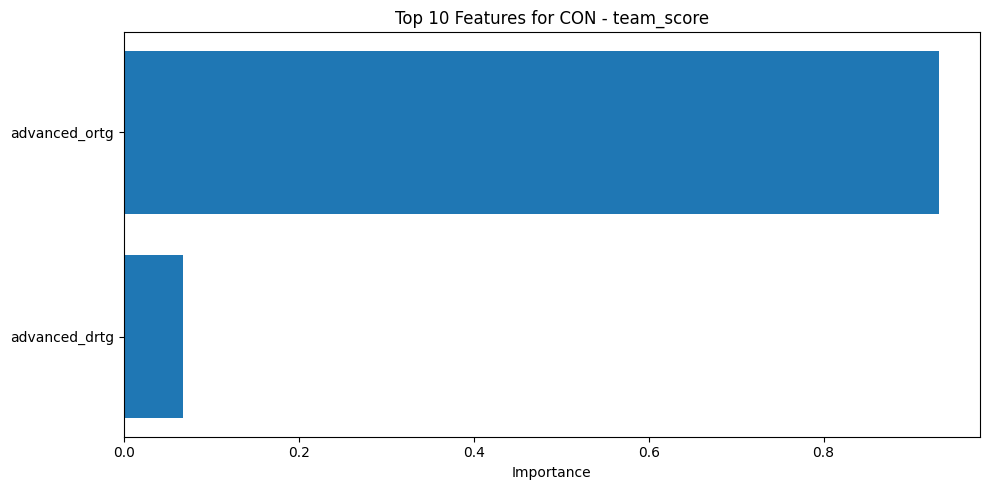

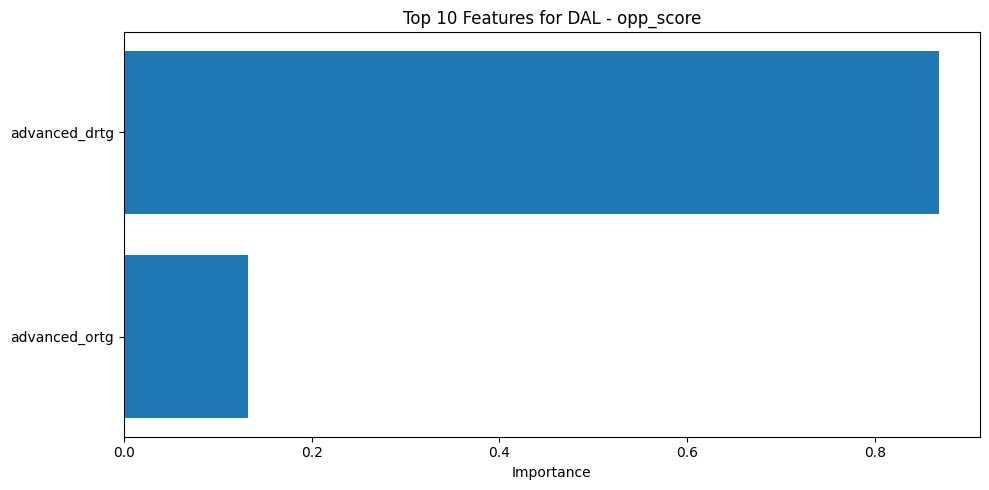

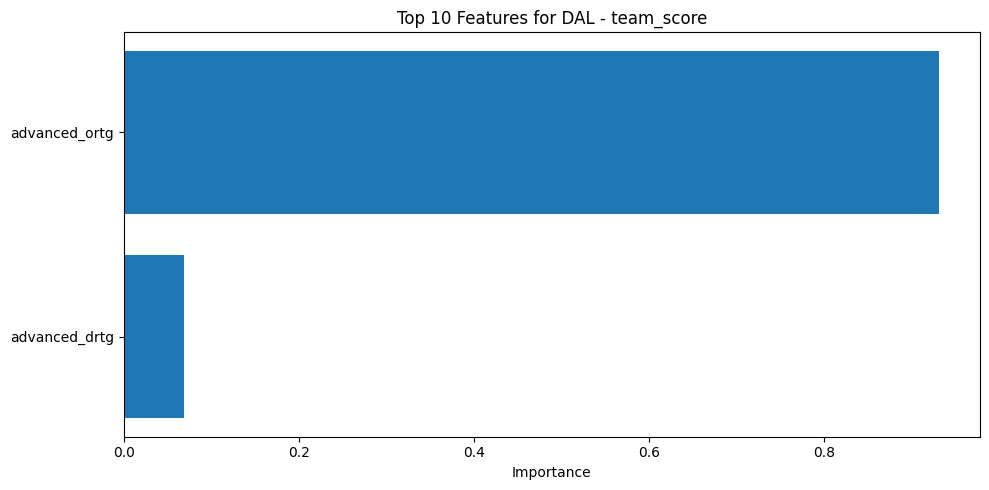

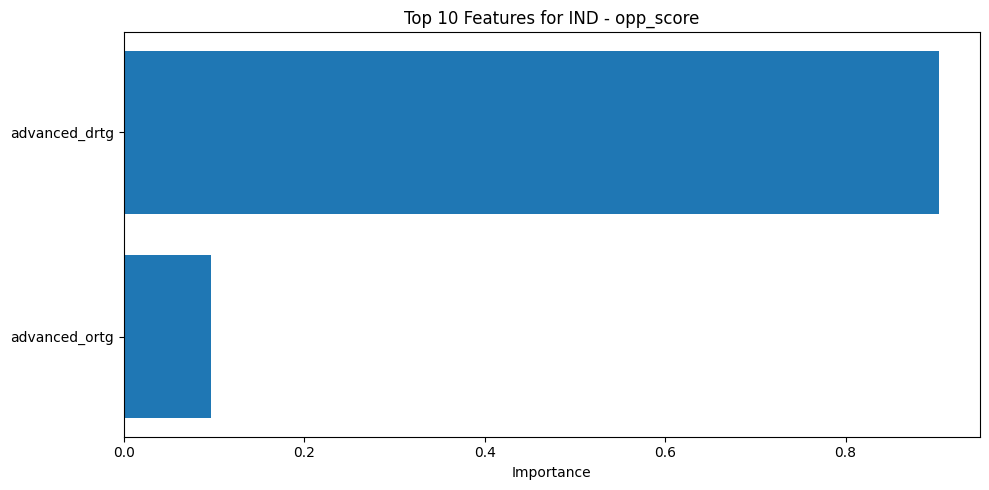

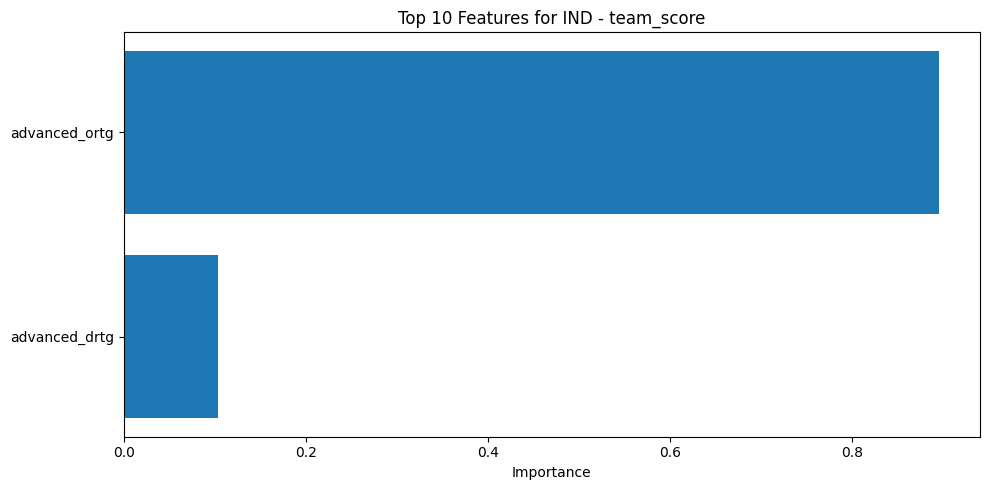

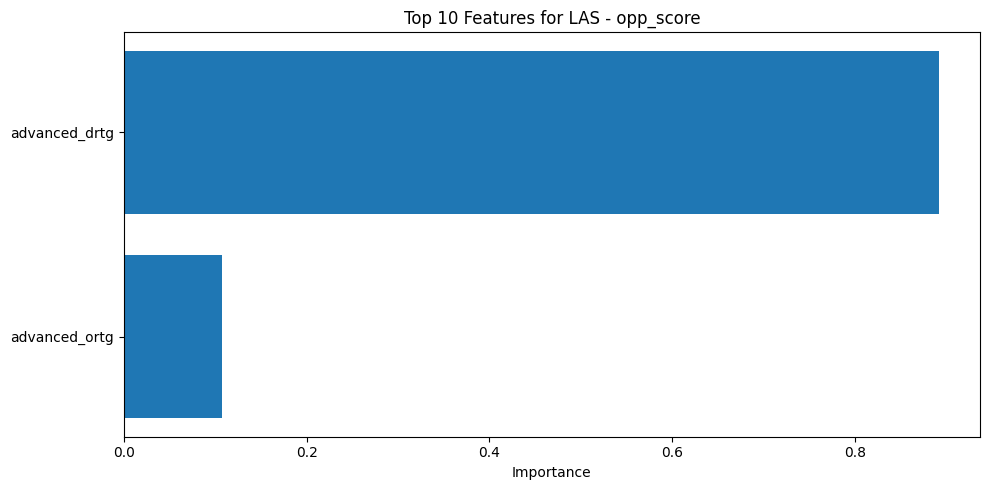

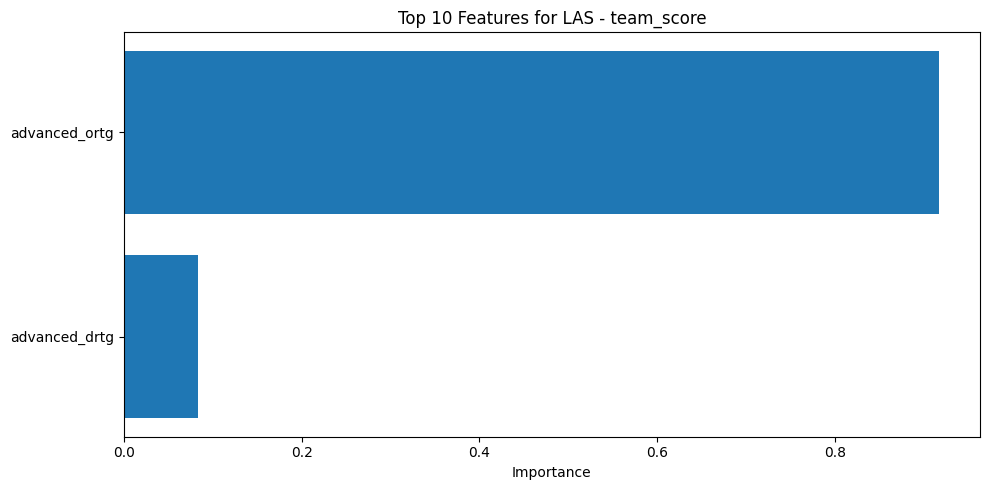

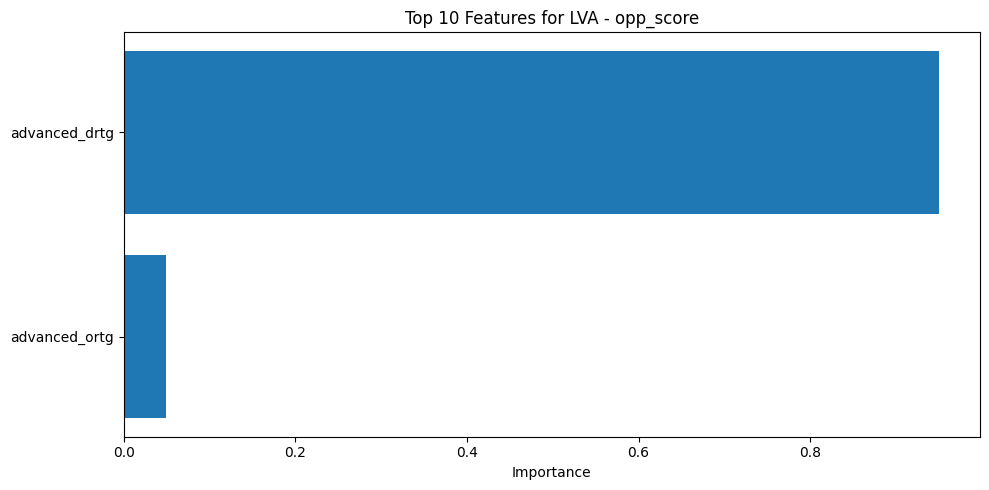

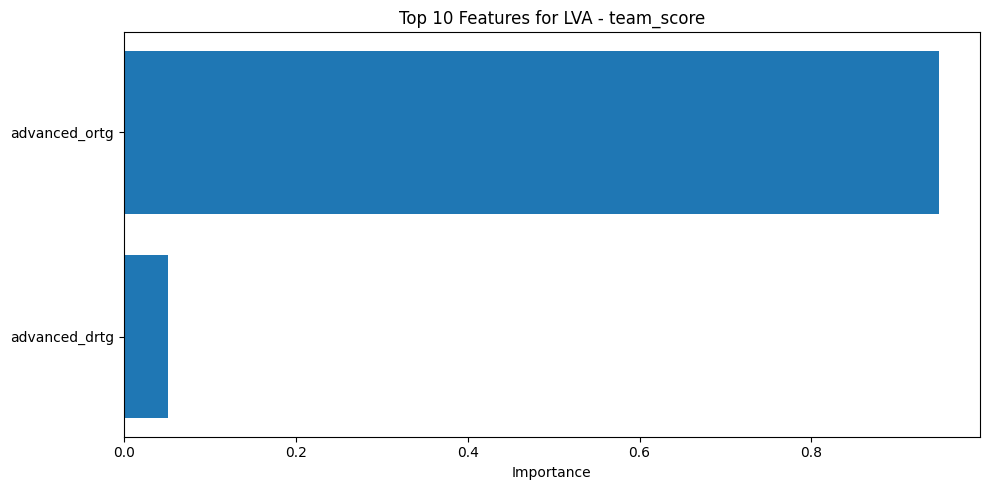

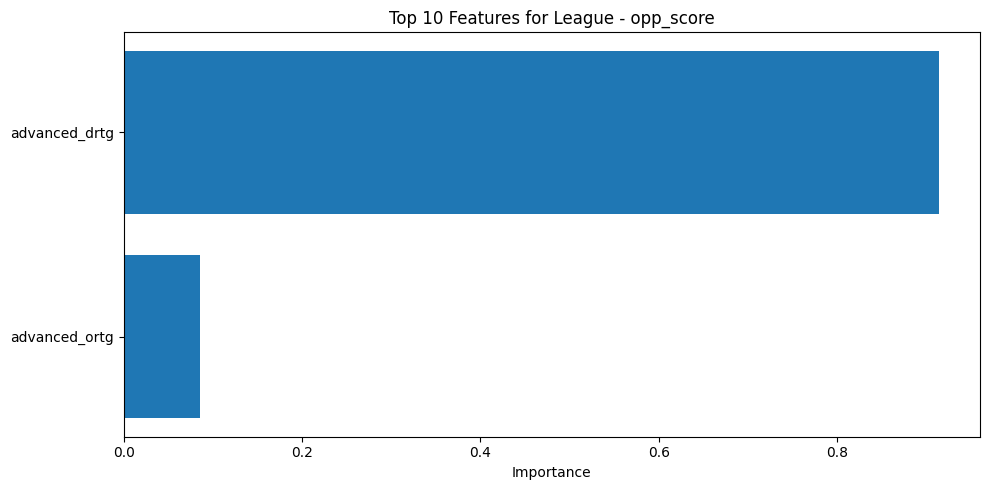

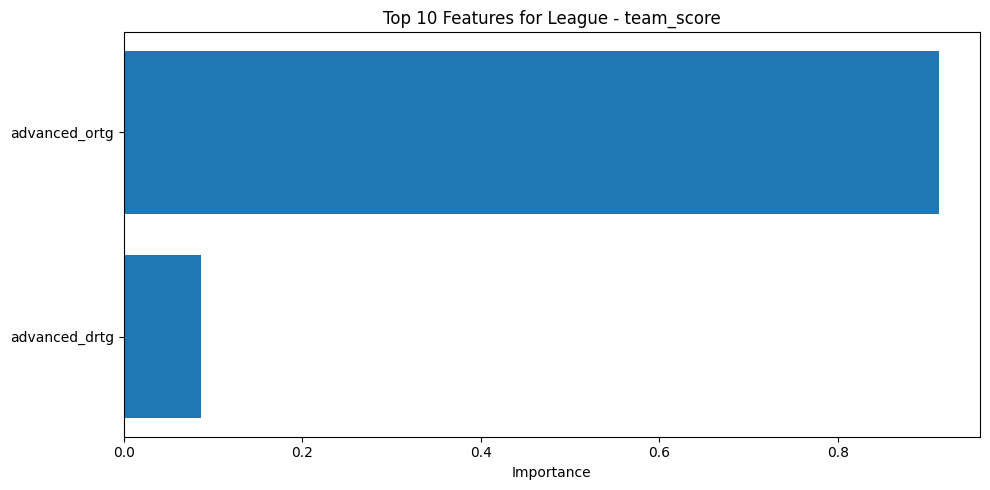

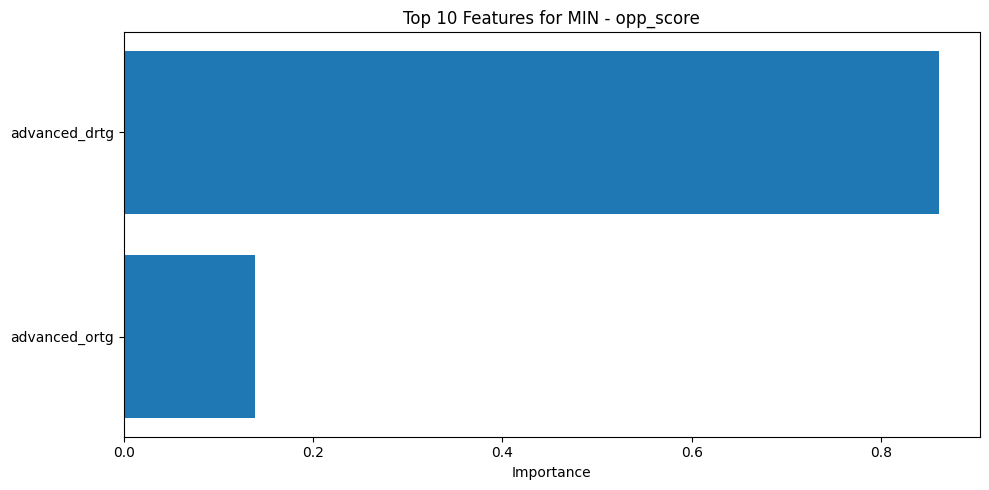

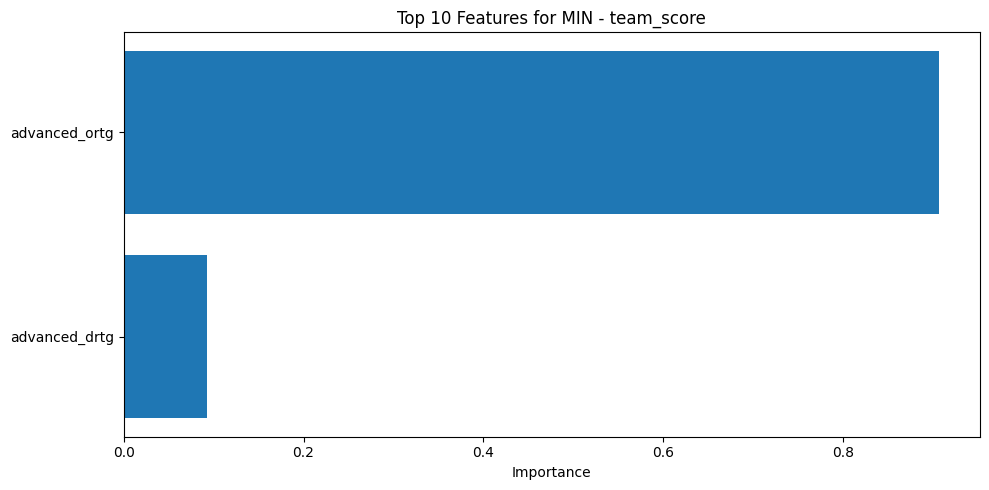

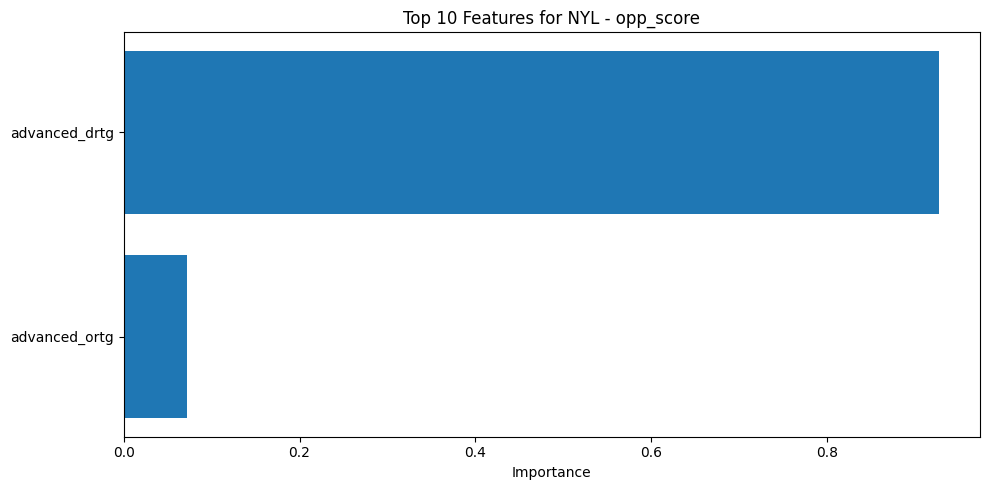

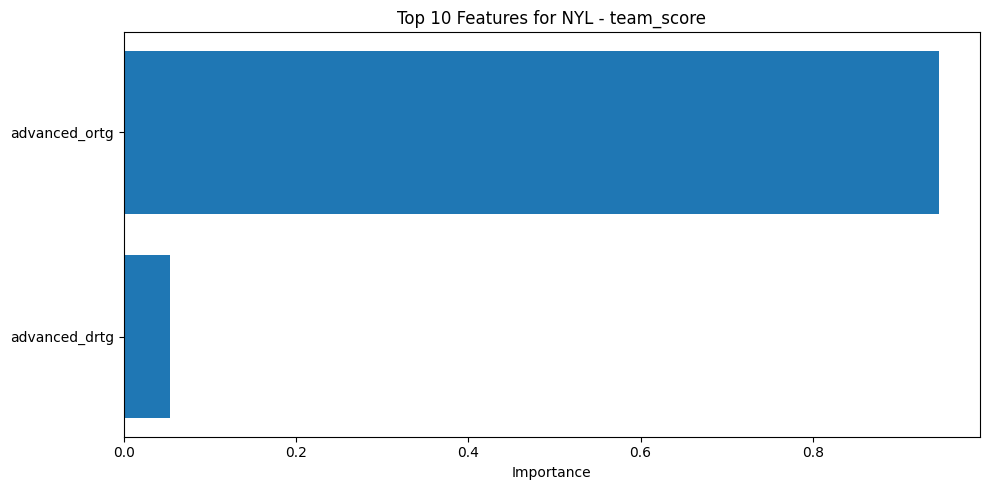

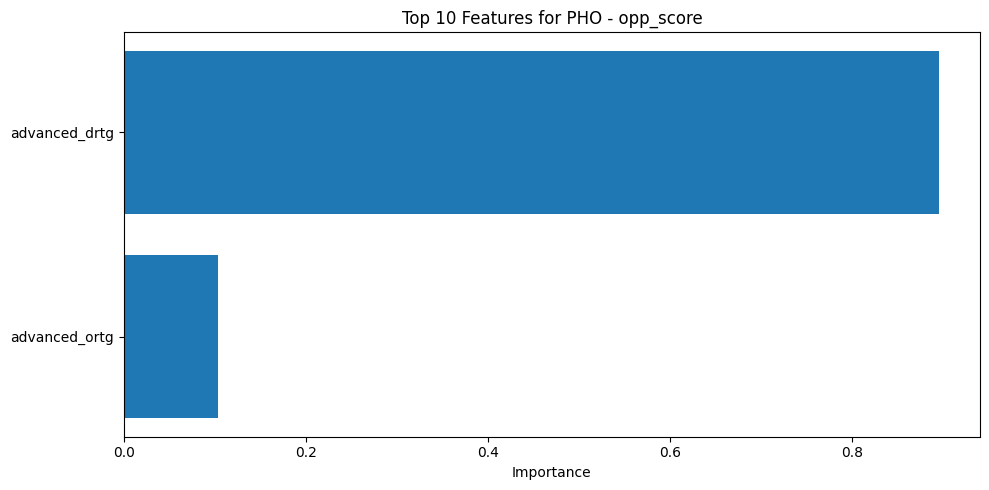

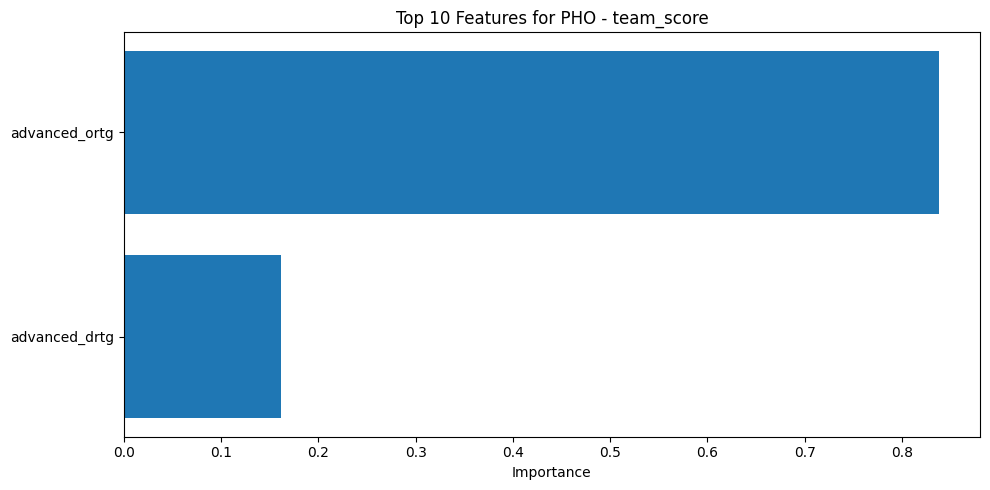

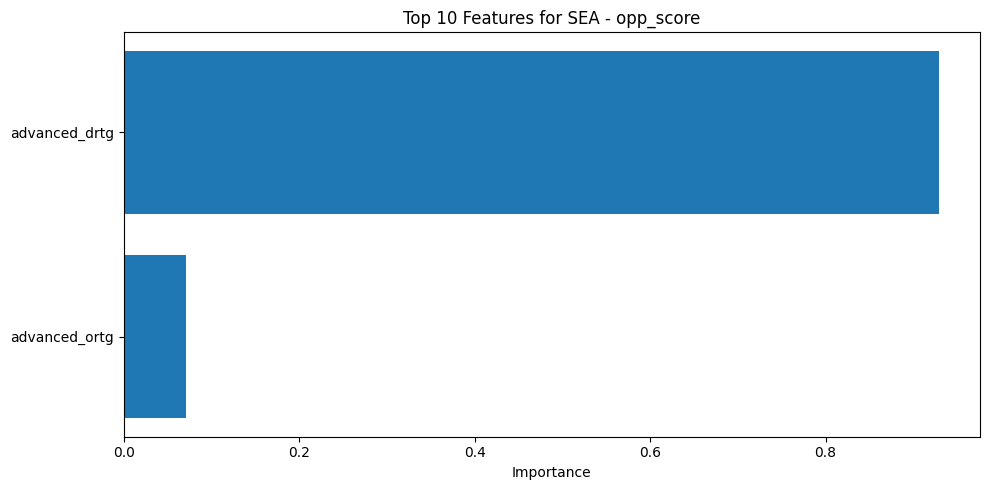

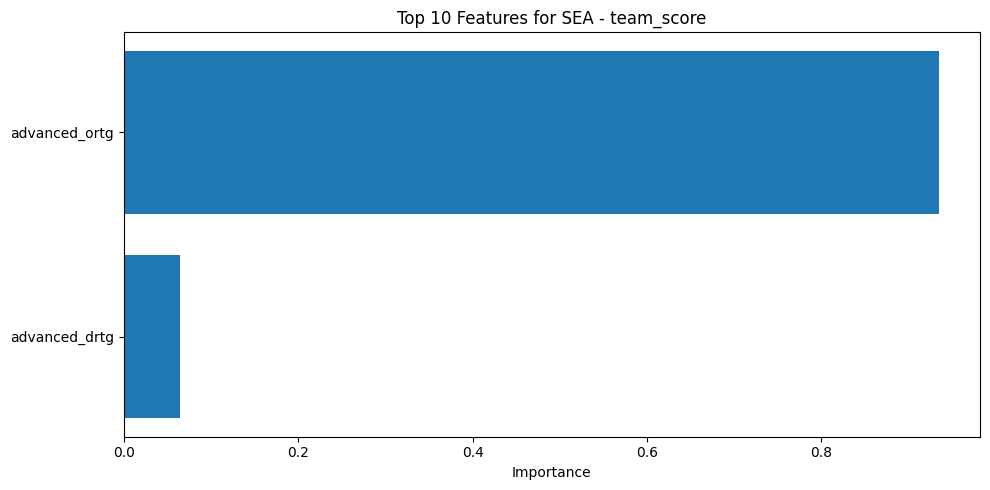

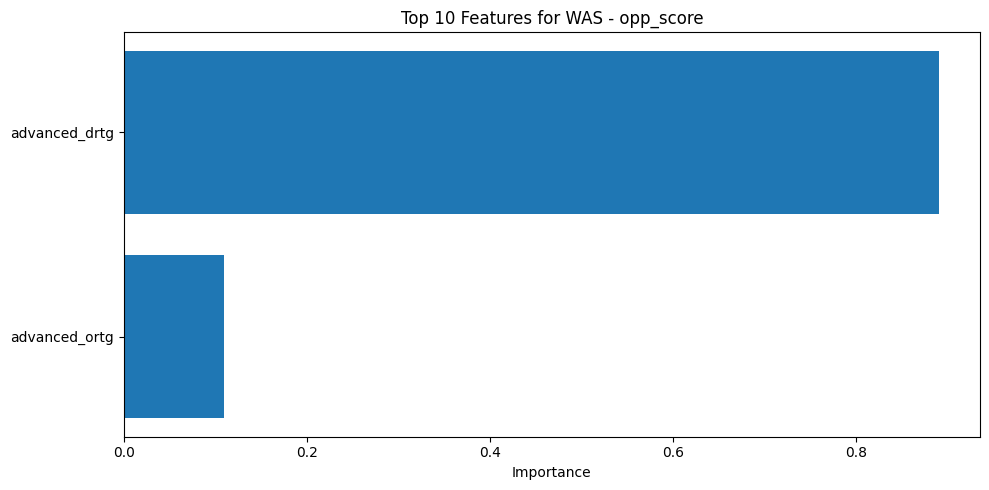

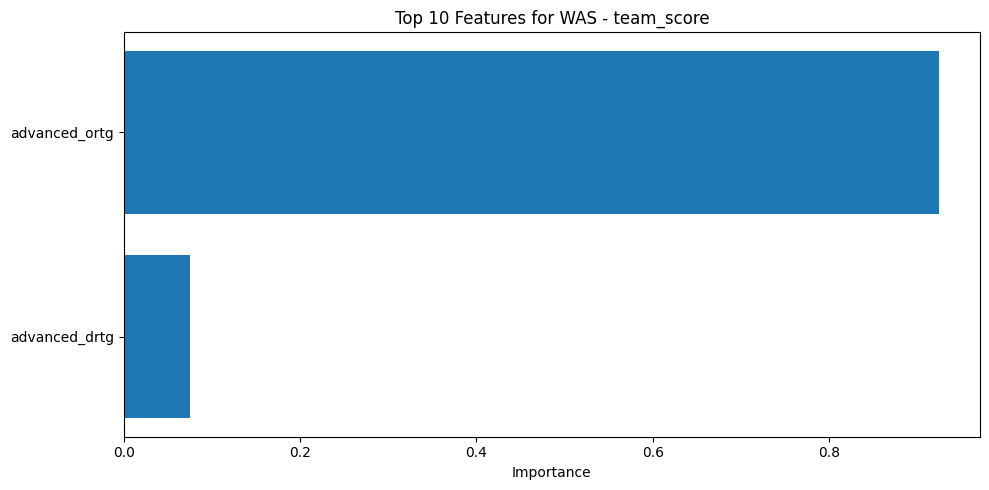

In [31]:
# Group by team + target and get top 10 features by importance
top_features = (
    importances_df.groupby(['Model', 'Target'])
    .apply(lambda group: group.sort_values('Importance', ascending=False).head(10))
    .reset_index(drop=True)
)

# Plot each team/target combo
for (model, target), group in top_features.groupby(['Model', 'Target']):
    plt.figure(figsize=(10, 5))
    plt.barh(group['Feature'], group['Importance'])
    plt.xlabel("Importance")
    plt.title(f"Top 10 Features for {model} - {target}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [32]:
# Save model MAE summary
mae_summary.to_csv("wnba_model_summary_baseline.csv", index=False)

# Save model predictions
predictions_df.to_csv("wnba_model_predictions_baseline.csv", index=False)

# Save model importances
importances_df.to_csv("wnba_model_feature_importance_baseline.csv", index=False)

# download all three CSVs
files.download("wnba_model_feature_importance_baseline.csv")
files.download("wnba_model_predictions_baseline.csv")
files.download("wnba_model_summary_baseline.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# targets
target_cols = ["team_score", "opp_score"]

# models to train: 12 teams + league-wide
teams = df["team"].unique().tolist() + ["League"]

# store overall results summary
results = []

# store row-level predictions
all_predictions = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features: drop non-feature columns
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score", "advanced_ortg", "advanced_drtg"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # track team + opp info from original df
    meta = df_team.loc[y_test.index, ["team", "opp", "team_score", "opp_score"]].reset_index(drop=True)

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    # compute row-level absolute errors
    team_score_mae = np.abs(y_pred[:, 0] - meta["team_score"].values)
    opp_score_mae = np.abs(y_pred[:, 1] - meta["opp_score"].values)

    # build prediction rows
    for i in range(len(meta)):
        all_predictions.append({
            "Model": team_name,
            "team": meta.loc[i, "team"],
            "opp": meta.loc[i, "opp"],
            "team_score": meta.loc[i, "team_score"],
            "team_score_pred": y_pred[i, 0],
            "team_score_mae": team_score_mae[i],
            "opp_score": meta.loc[i, "opp_score"],
            "opp_score_pred": y_pred[i, 1],
            "opp_score_mae": opp_score_mae[i],
        })

    # overall summary metrics
    for i, col in enumerate(target_cols):
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        results.append({
            "Model": team_name,
            "Target": col,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

# create final prediction DataFrame
predictions_df = pd.DataFrame(all_predictions)

# preview
predictions_df.head()

Model team  opp  team_score  team_score_pred  team_score_mae  opp_score  \
0   ATL  ATL  CON          67            80.99           13.99         80   
1   ATL  ATL  NYL          75            81.27            6.27         81   
2   ATL  ATL  CON          78            84.66            6.66         74   
3   ATL  ATL  PHO          72            70.34            1.66         63   
4   ATL  ATL  WAS          73            82.09            9.09         67   

   opp_score_pred  opp_score_mae  
0           81.87           1.87  
1           80.94           0.06  
2           77.23           3.23  
3           76.60          13.60  
4           78.10          11.10

In [34]:
mae_summary = (
    predictions_df
    .groupby("Model")[["team_score_mae", "opp_score_mae"]]
    .agg(["min", "max", "mean", "median"])
    .reset_index()
)

# optional: flatten column names
mae_summary.columns = ['_'.join(col).strip('_') for col in mae_summary.columns]

mae_summary

Model  team_score_mae_min  team_score_mae_max  team_score_mae_mean  \
0      ATL                1.66               13.99             7.765000   
1      CHI                0.56               17.98             7.331250   
2      CON                1.13                9.86             4.417500   
3      DAL                0.14                7.67             2.703750   
4      IND                1.18                4.21             2.627500   
5      LAS                1.21               11.86             5.471250   
6      LVA                0.44               10.83             4.967500   
7   League                0.09               15.05             3.973854   
8      MIN                0.08               12.80             6.437500   
9      NYL                0.66                5.70             2.598750   
10     PHO                1.99               10.49             5.465000   
11     SEA                0.30                7.96             3.073750   
12     WAS                0.58               10.56             5.137500   

    team_score_mae_median  opp_score_mae_min  opp_score_mae_max  \
0                   7.000               0.06              13.60   
1                   5.810               0.94               8.45   
2                   3.920               1.10              13.08   
3                   1.210               1.45               9.13   
4                   2.480               1.24               7.27   
5                   5.140               1.68               6.09   
6                   4.775               1.84              11.85   
7                   2.780               0.13              18.31   
8                   6.855               0.99              12.27   
9                   1.860               1.81              12.43   
10                  3.710               2.87              16.30   
11                  3.050               0.56               8.83   
12                  4.995               0.68              12.13   

    opp_score_mae_mean  opp_score_mae_median  
0             5.805000                 3.960  
1             4.172500                 3.975  
2             6.298750                 5.015  
3             4.225000                 3.320  
4             4.337500                 4.320  
5             3.452500                 3.045  
6             6.592500                 5.945  
7             3.790521                 2.940  
8             4.892500                 4.770  
9             5.931250                 4.900  
10           10.406250                10.705  
11            5.157500                 4.790  
12            4.693750                 3.605

In [37]:
# store importances for all models
all_importances = []

for team_name in teams:
    # subset data
    if team_name == "League":
        df_team = df.copy()
    else:
        df_team = df[df["team"] == team_name].copy()

    # features
    X = df_team.drop(columns=["team", "opp", "team_score", "opp_score", "advanced_ortg", "advanced_drtg"])
    y = df_team[["team_score", "opp_score"]]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # model
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)

    # get feature importances from both estimators
    team_score_importance = model.estimators_[0].feature_importances_
    opp_score_importance = model.estimators_[1].feature_importances_

    # stack into rows
    for i, feature in enumerate(X.columns):
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "team_score",
            "Importance": team_score_importance[i]
        })
        all_importances.append({
            "Model": team_name,
            "Feature": feature,
            "Target": "opp_score",
            "Importance": opp_score_importance[i]
        })

# build final DataFrame
importances_df = pd.DataFrame(all_importances)

# optional: sort by importance descending
importances_df = importances_df.sort_values(by="Importance", ascending=False)

importances_df.head(20)

Model                            Feature      Target  Importance
1191     PHO                    opponent_fg_pct   opp_score    0.630316
784      LVA                    advanced_ts_pct  team_score    0.625704
912      MIN                    advanced_ts_pct  team_score    0.604378
16       ATL                    advanced_ts_pct  team_score    0.600019
400      DAL                    advanced_ts_pct  team_score    0.556177
1584  League  team_vs_opp_homeaway_median_score  team_score    0.537251
1040     NYL                    advanced_ts_pct  team_score    0.528838
1296     SEA                    advanced_ts_pct  team_score    0.526974
1168     PHO                    advanced_ts_pct  team_score    0.505323
1559  League     defensive_four_factors_efg_pct   opp_score    0.487851
560      IND  team_vs_opp_homeaway_median_score  team_score    0.485776
1456     WAS  team_vs_opp_homeaway_median_score  team_score    0.468828
295      CON                    opponent_fg_pct   opp_score    0.454305
407      DAL     defensive_four_factors_efg_pct   opp_score    0.438556
1303     SEA     defensive_four_factors_efg_pct   opp_score    0.435809
688      LAS  team_vs_opp_homeaway_median_score  team_score    0.370811
791      LVA     defensive_four_factors_efg_pct   opp_score    0.364807
272      CON                    advanced_ts_pct  team_score    0.359412
935      MIN                    opponent_fg_pct   opp_score    0.341621
176      CHI  team_vs_opp_homeaway_median_score  team_score    0.333988

In [39]:
# optional: sort by importance descending
importances_df = importances_df.sort_values(by="Importance", ascending=True)

importances_df.head(20)

Model             Feature      Target  Importance
467    DAL  Elizabeth Williams   opp_score         0.0
309    CON         A'ja Wilson   opp_score         0.0
577    IND       Azura Stevens   opp_score         0.0
578    IND     Breanna Stewart  team_score         0.0
579    IND     Breanna Stewart   opp_score         0.0
580    IND    Bridget Carleton  team_score         0.0
581    IND    Bridget Carleton   opp_score         0.0
1214   PHO    Arike Ogunbowale  team_score         0.0
1215   PHO    Arike Ogunbowale   opp_score         0.0
1216   PHO       Azura Stevens  team_score         0.0
1217   PHO       Azura Stevens   opp_score         0.0
1218   PHO     Breanna Stewart  team_score         0.0
255    CHI        Tina Charles   opp_score         0.0
466    DAL  Elizabeth Williams  team_score         0.0
1276   PHO       Temi Fagbenle  team_score         0.0
469    DAL        Ezi Magbegor   opp_score         0.0
470    DAL        Jackie Young  team_score         0.0
1207   PHO     Aaliyah Edwards   opp_score         0.0
564    IND         A'ja Wilson  team_score         0.0
565    IND         A'ja Wilson   opp_score         0.0

<ipython-input-38-7fd42919fbe4>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sort_values('Importance', ascending=False).head(10))


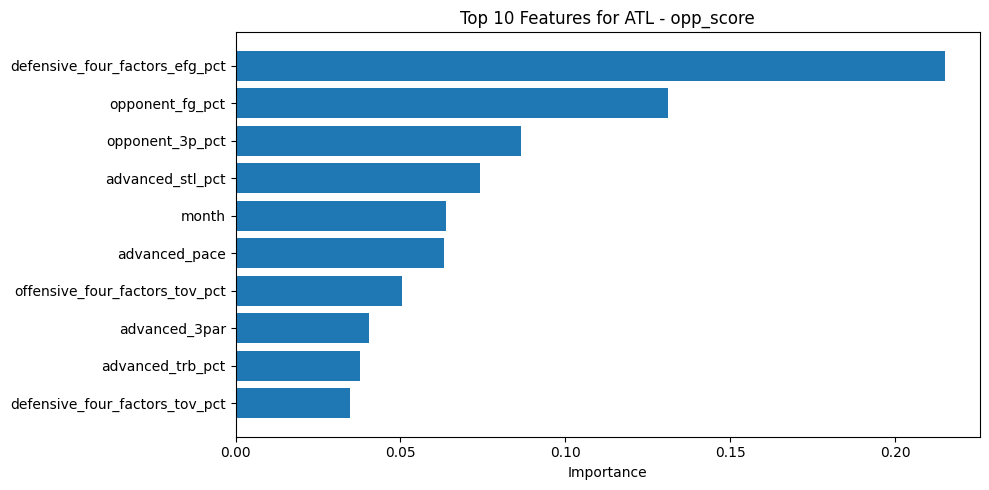

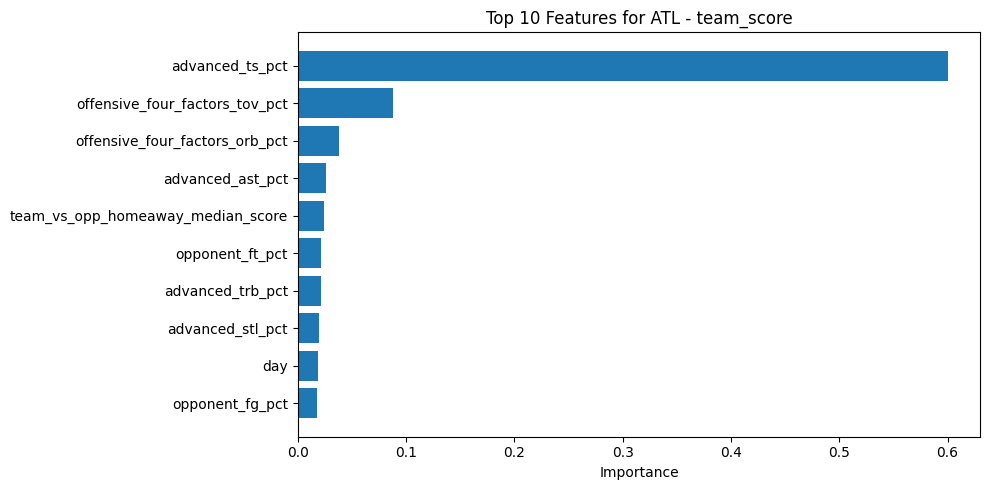

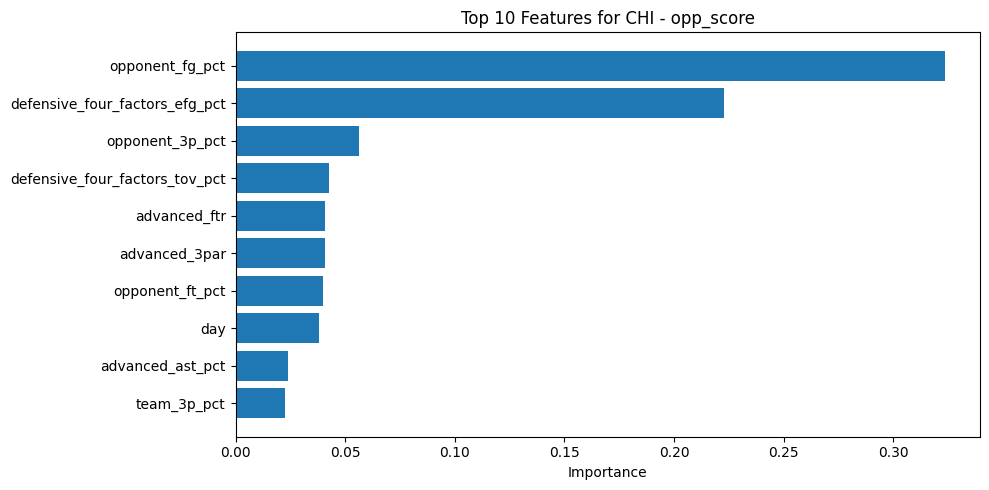

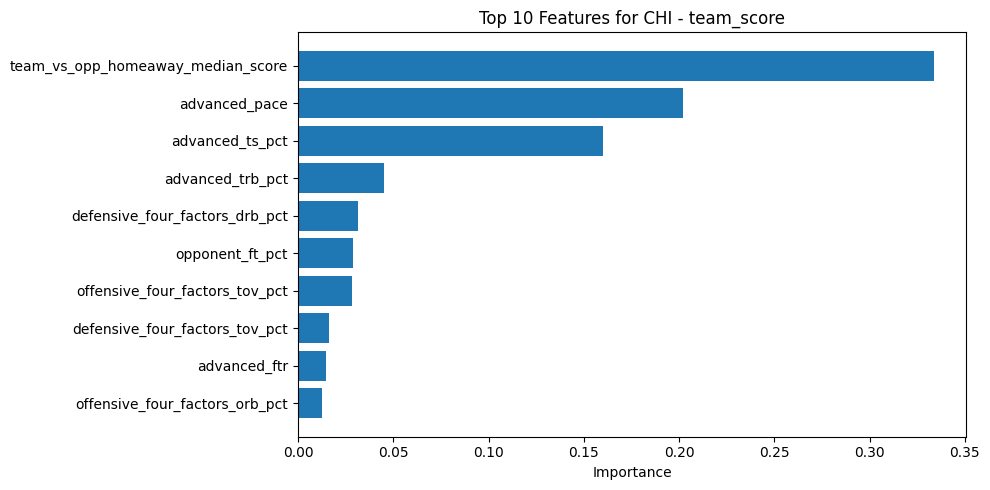

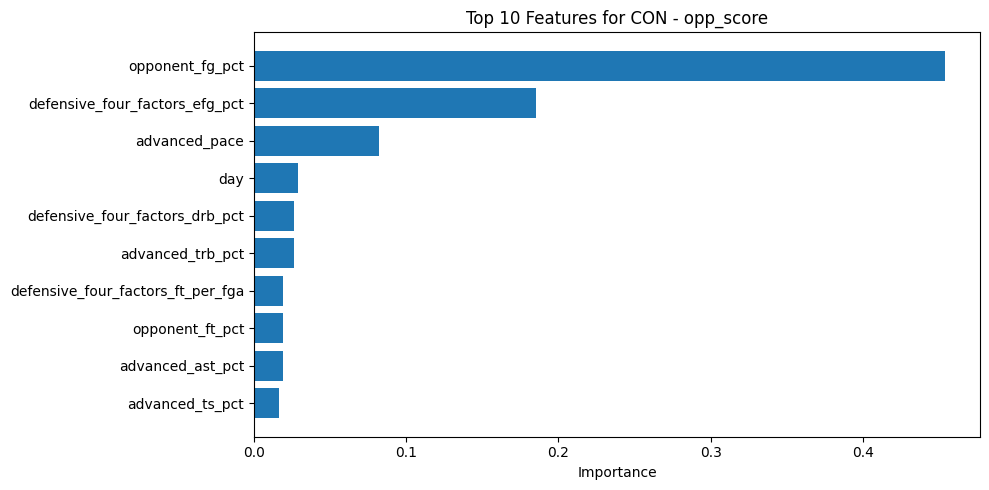

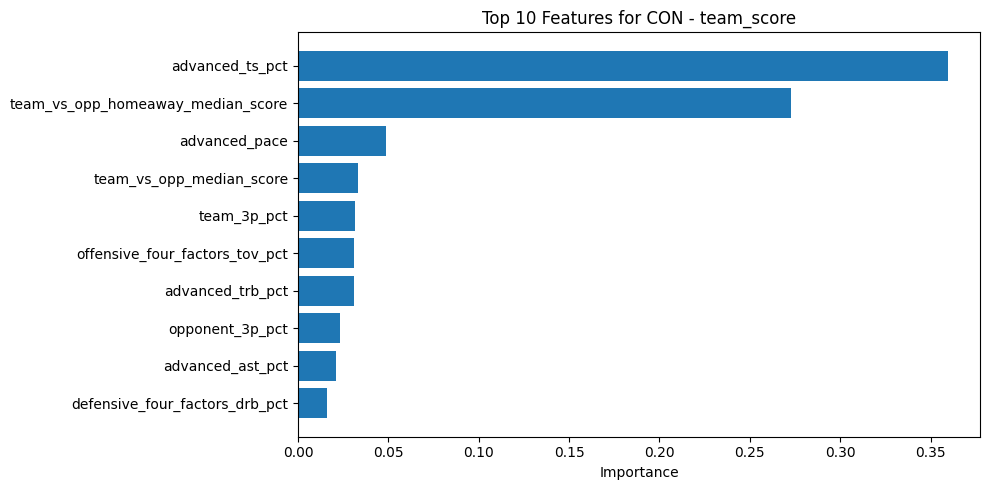

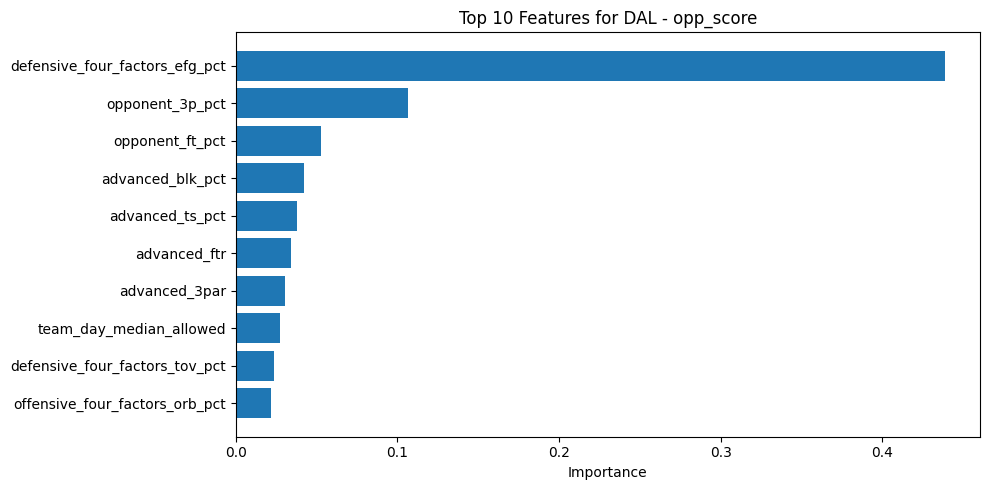

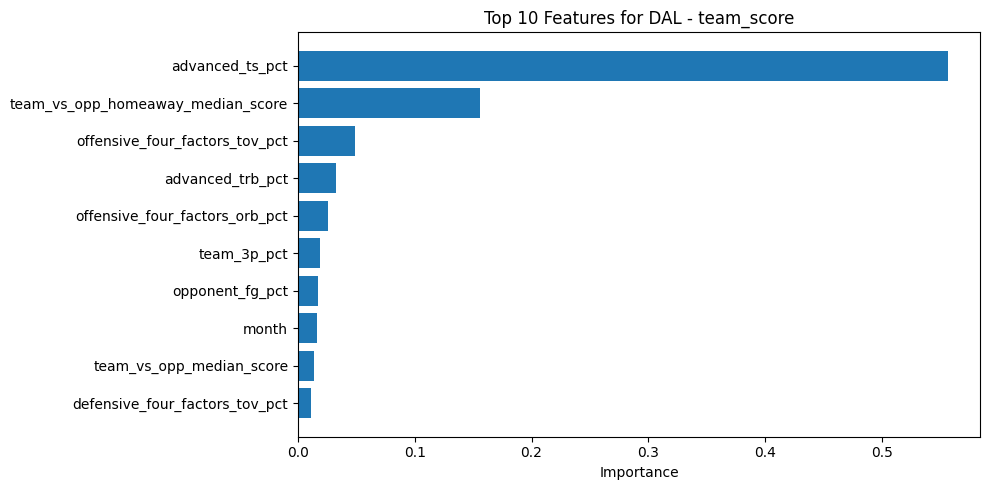

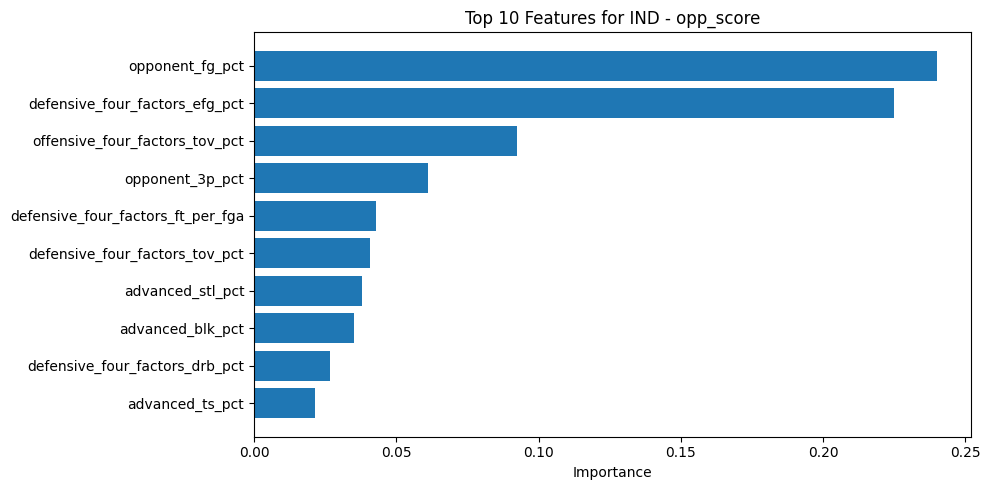

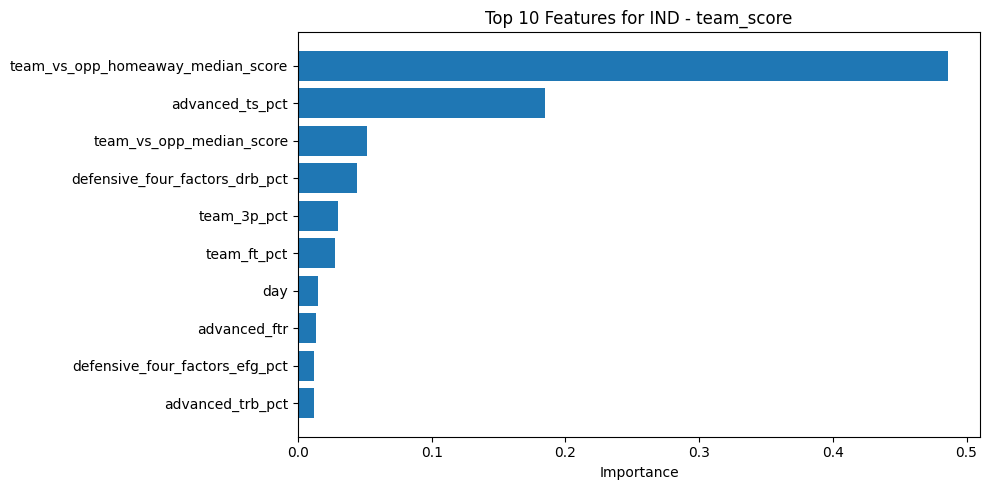

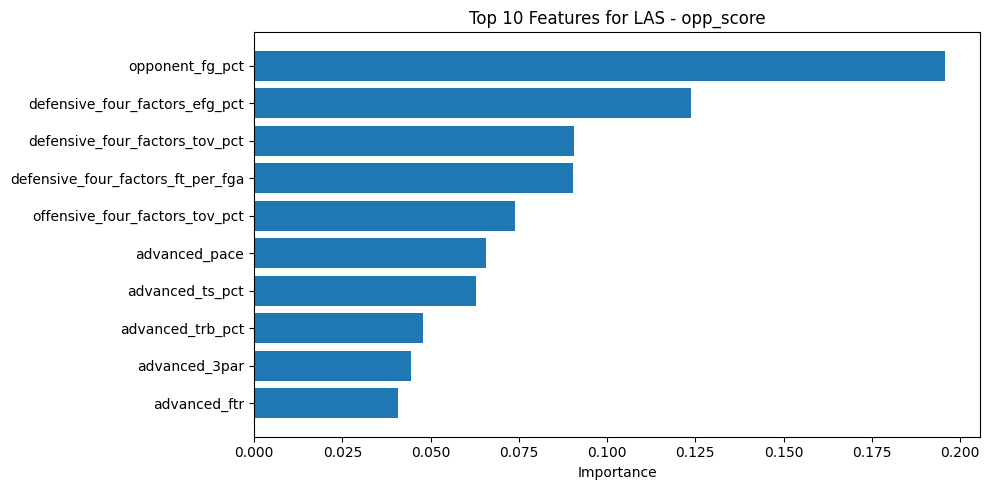

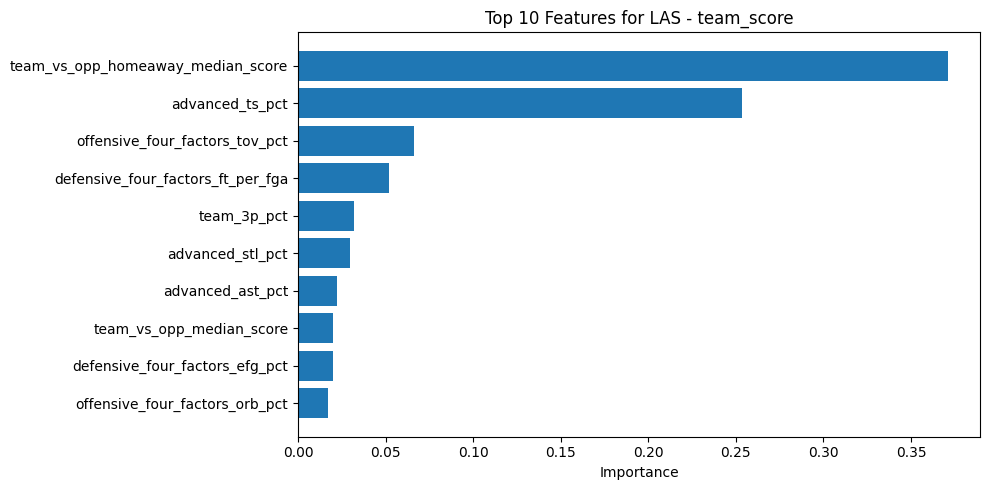

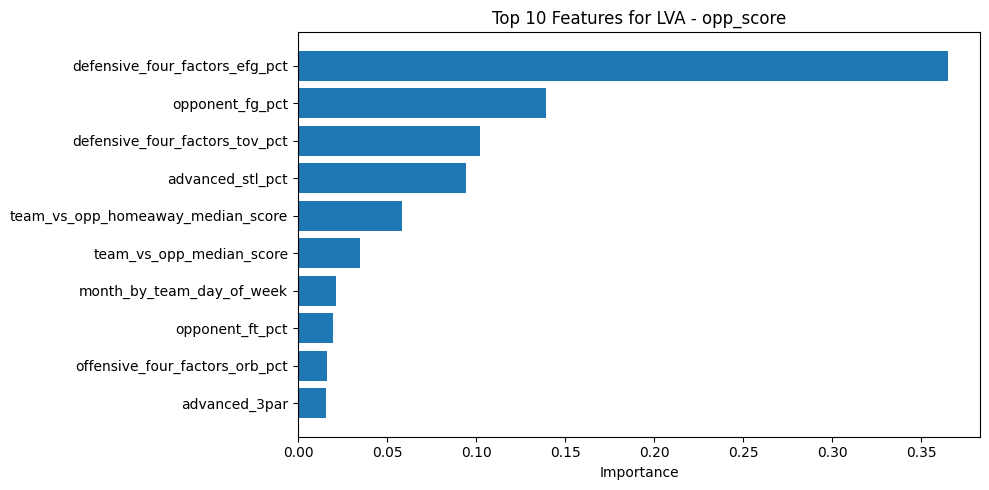

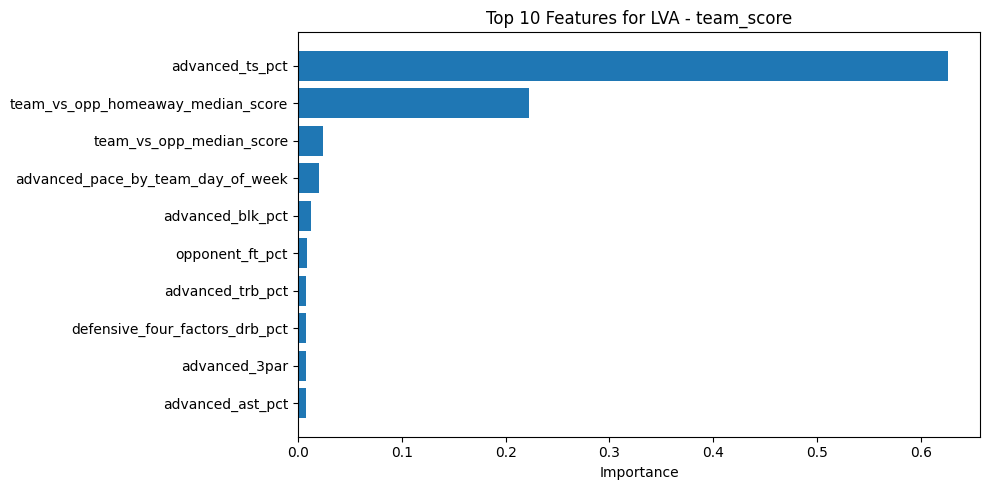

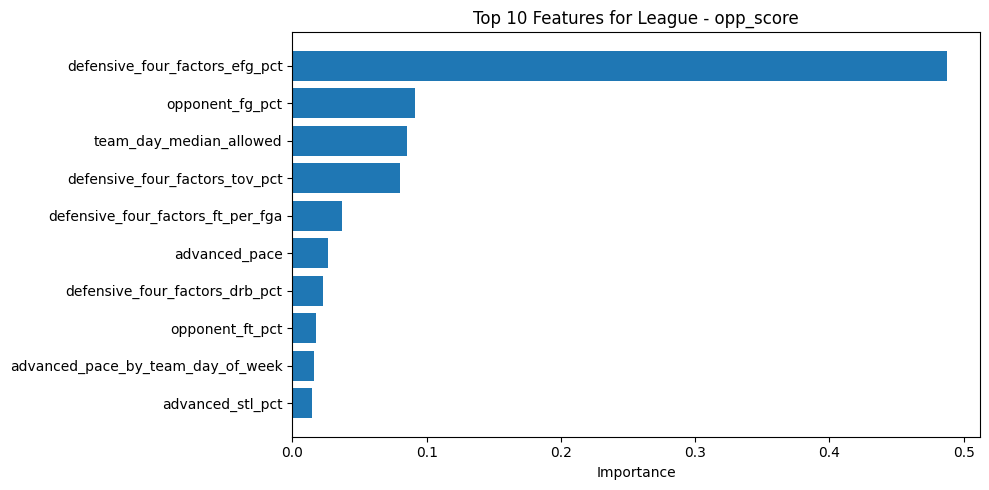

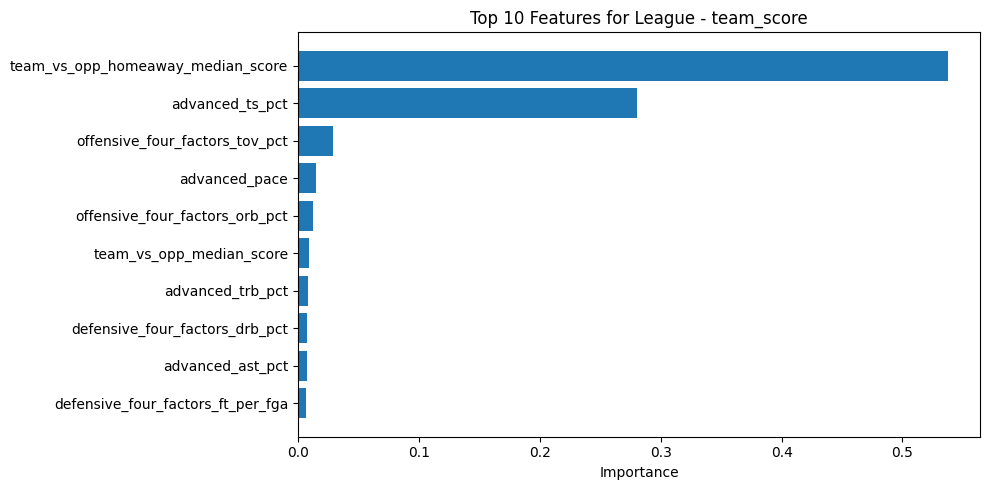

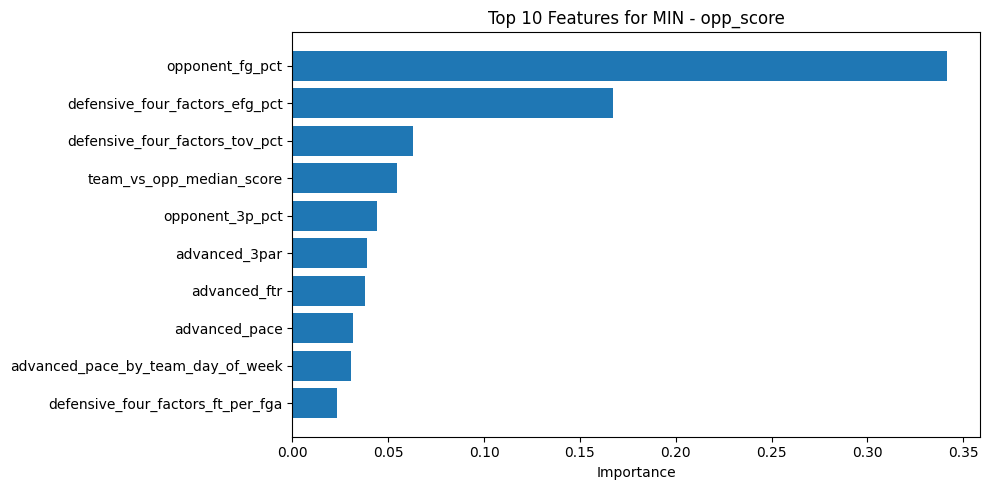

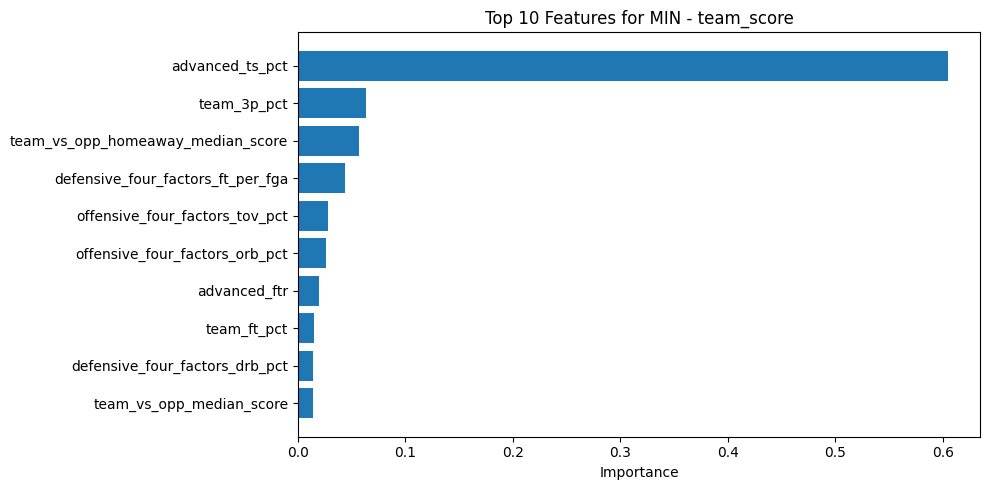

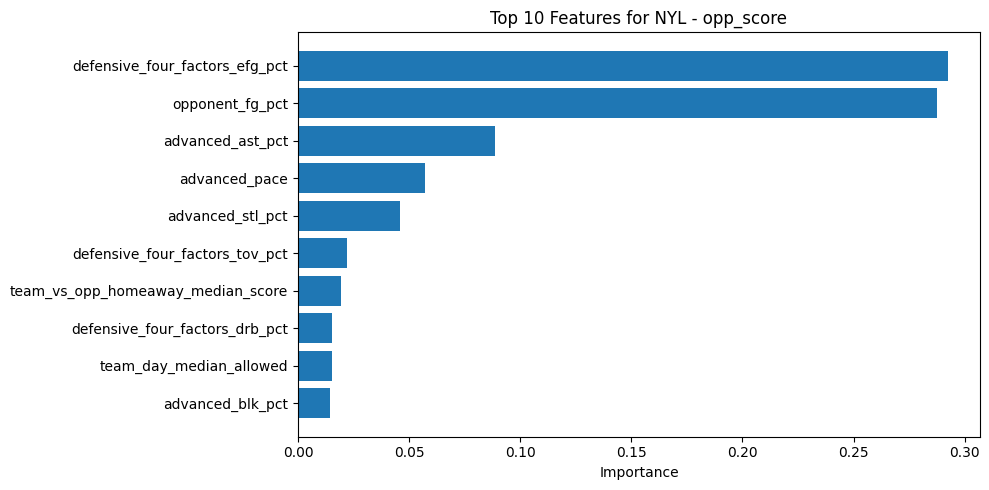

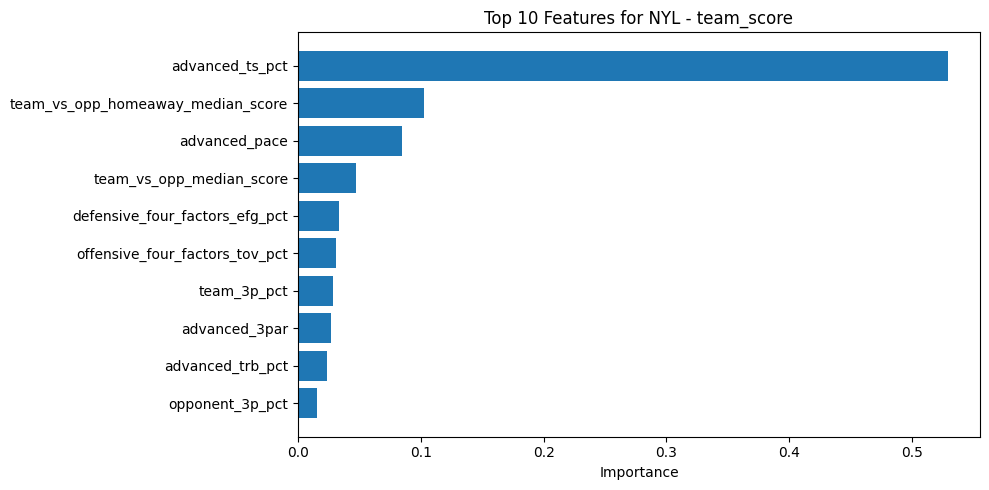

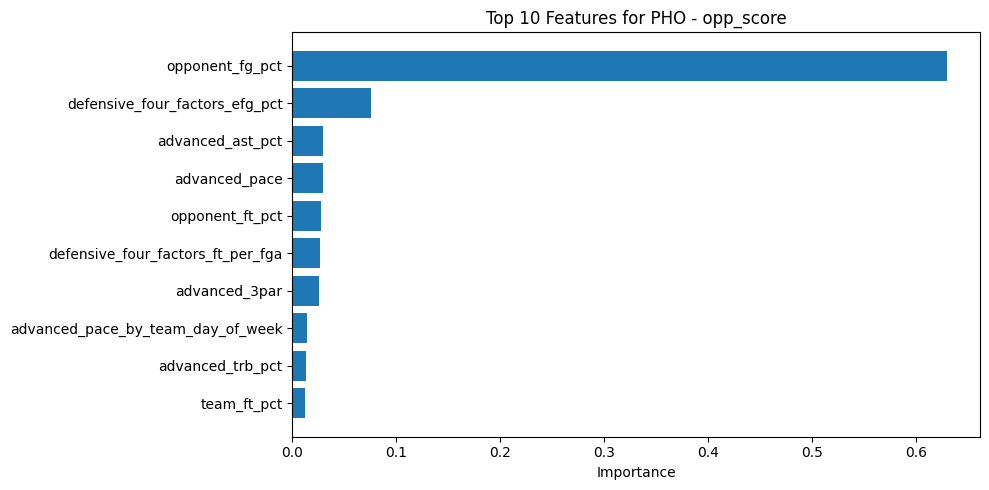

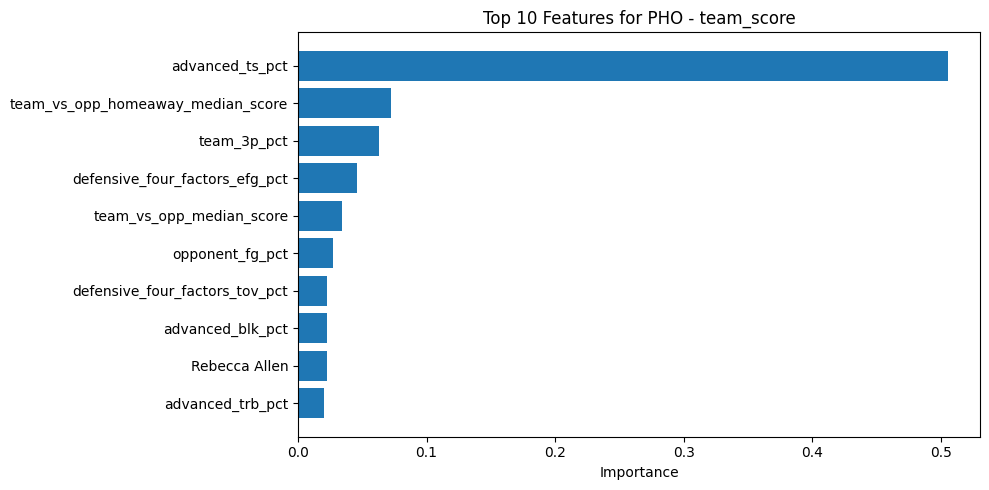

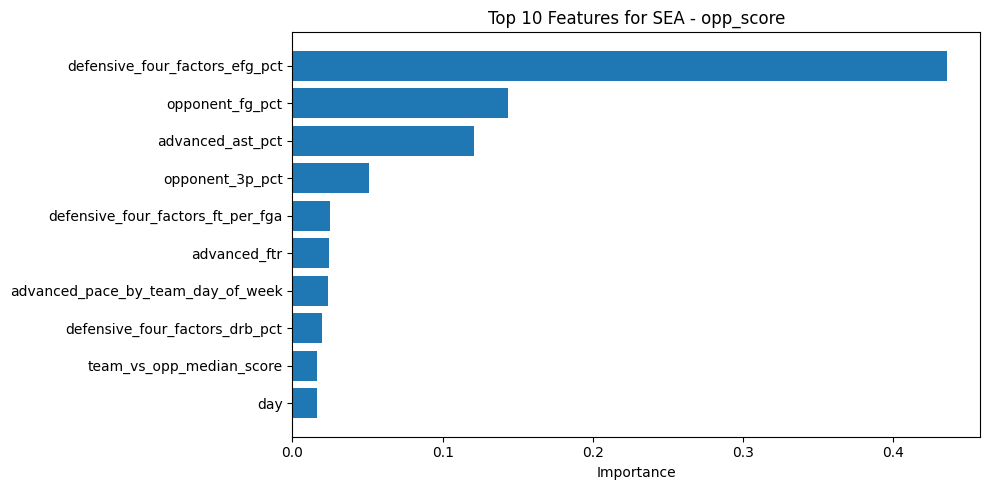

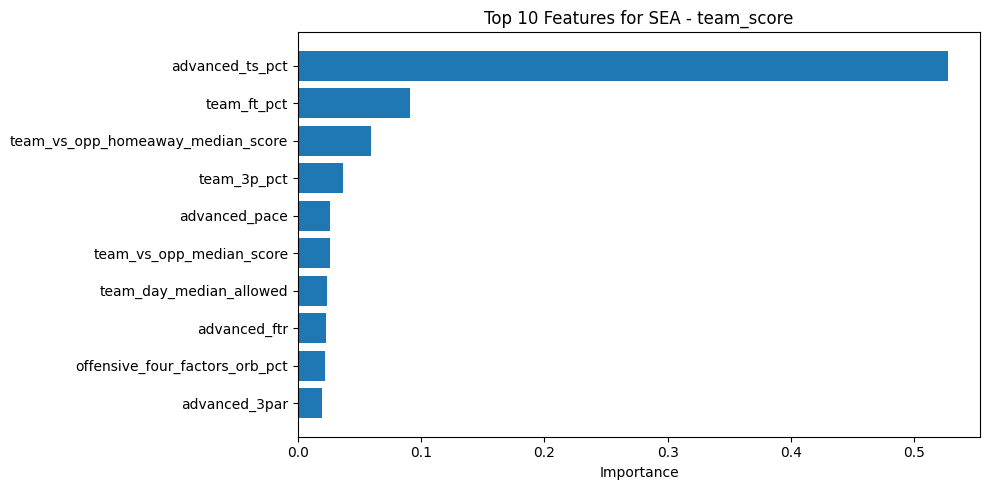

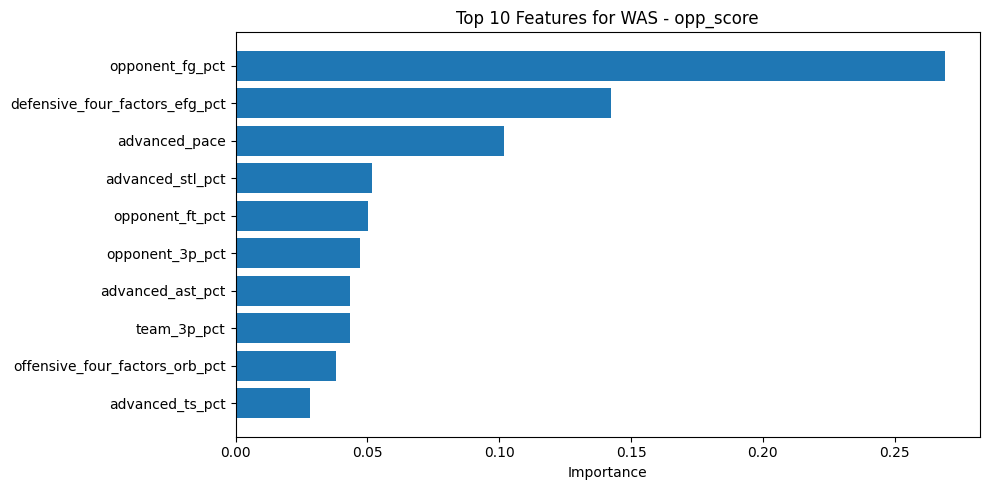

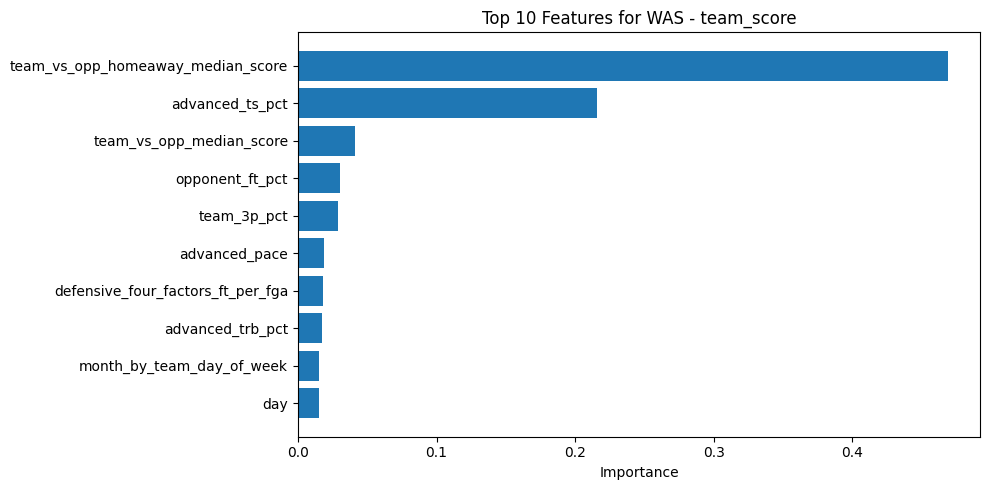

In [38]:
# Group by team + target and get top 10 features by importance
top_features = (
    importances_df.groupby(['Model', 'Target'])
    .apply(lambda group: group.sort_values('Importance', ascending=False).head(10))
    .reset_index(drop=True)
)

# Plot each team/target combo
for (model, target), group in top_features.groupby(['Model', 'Target']):
    plt.figure(figsize=(10, 5))
    plt.barh(group['Feature'], group['Importance'])
    plt.xlabel("Importance")
    plt.title(f"Top 10 Features for {model} - {target}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [41]:
# Save model MAE summary
mae_summary.to_csv("wnba_model_summary_without_baseline.csv", index=False)

# Save model predictions
predictions_df.to_csv("wnba_model_predictions_without_baseline.csv", index=False)

# Save model importances
importances_df.to_csv("wnba_model_feature_importance_without_baseline.csv", index=False)

# download all three CSVs
files.download("wnba_model_feature_importance_without_baseline.csv")
files.download("wnba_model_predictions_without_baseline.csv")
files.download("wnba_model_summary_without_baseline.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>